# Ghana Workshop Q1. Basic Mapping for Yield Estimate with GEE
This notebook will demonstrate some basic mapping tools within GEE and geemap libraries to:
1) visualize the vegetation data from exisiting satellite products, e.g. MODIS LAI and NDVI;  
2) plot county-level or district-level yield data from a csv file;  
3) mask the data with classified maize layer. 


In [1]:
from basic_plotting import *
import geemap, ee

Firstly, let's define the Map basic and Area of Interest (AOIs). You can define a simple lat/lon location with a pair of square brackets to define a Point of Interest (POI), or the lat/lon of four corners of a rectangular area. If you are interested in a particular administrative region, try the [Global Administrative Unit Layers (GAUL) polygons](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2?hl=en) to help define your AOI.

In [18]:
tamale_centre = [9.38, -0.68]
# alternatively, start with a GSSTI farm location with high expected yield of 1500 per acre
farm_7021YAM = [9.70065, -0.54129]

Map = geemap.Map(center=tamale_centre, zoom=9)

cities = ee.FeatureCollection("FAO/GAUL/2015/level2")
ghana_district = cities.filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
northern_district = ghana_district.filter(ee.Filter.eq('ADM1_NAME', 'Northern'))

northern_outline = ee.Image().byte().paint(**{
  'featureCollection': northern_district,
  'color': 1,
  'width': 2
})

Map.addLayer(northern_outline, {}, 'Ghana districts')

Now we have set up some basic POIs, AOIs, and an outline for the Northern Districts as well. In order to visualise or refresh the GEE Map, simply call 'Map' in a code cell:

In [20]:
Map

Map(bottom=62405.0, center=[9.38, -0.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

## Load MODIS data collections from GEE
Next, let's load some MODIS data for Northern Ghana. I've defined here a python function called `load_modis_band` to do so. It automatically loads the [MODIS MOD13Q1 NDVI/EVI](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1), the [MODIS MCD15A3H Lai](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD15A3H) or the [MODIS MCD12Q1 LandCover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1) image collections from GEE's data catalog and also calculates the annual means values for the specific band for a specific year. 

In [57]:
def plot_modis_band(band='Lai', year=2018):
    
    reducer = 'mean'
    
    band_yearly, band_reduced = load_modis_band(band, year, northern_district, reducer)

    Map = geemap.Map(center=farm_7021YAM, zoom=9)
    Map.addLayer(band_reduced, colorized_vis['Lai'], f'{reducer} {band} {year}')
    Map.addLayer(outline, {}, 'Ghana districts')
    return Map, band_yearly
    
Map, lai_2018 = plot_modis_band(band='Lai', year=2018)
Map

MODIS Lai and mean both SUCCESS for 2018


Map(center=[9.70065, -0.54129], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [67]:
print(lai_2018.next().get('system:index').getInfo())

AttributeError: 'ImageCollection' object has no attribute 'next'

In [54]:
lc_crop, lc_all = load_modis_lc('LC_Type3', 2018, northern_district, cropclasses=[1])
Map.addLayer(lc_crop, {'min':0, 'max':1}, f"GrasslandsType3 2018", opacity=0.7)

MODIS LC_Type3 and mean both SUCCESS for 2018


In [56]:
print(lai_2018.first().getInfo())
date = lai_2018.first().get('system:index').getInfo()
#refresh_base_map()
Map.addLayer(lai_2018.first(), colorized_vis['Lai'], f'Lai {date}')
Map

{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'properties': {'system:index': '2018_06_02'}}


Map(bottom=62287.0, center=[9.70065, -0.54129], controls=(WidgetControl(options=['position', 'transparent_bg']…

In [563]:
lc_crop, lc_all = load_modis_lc('LC_Type2', 2018, northern_district, cropclasses=[10])
Map.addLayer(lc_crop, {'min':0, 'max':1}, f"GrasslandsType2 2018", opacity=0.7)

MODIS LC_Type2 and mean both SUCCESS for 2018


In [92]:
lai_2018.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'id': 'MODIS/006/MCD15A3H',
 'version': 1645359694044367,
 'properties': {'system:visualization_0_min': '0.0',
  'type_name': 'ImageCollection',
  'keywords': ['4-day',
   'fpar',
   'global',
   'lai',
   'mcd115a3h',
   'modis',
   'nasa',
   'usgs',
   'vegetation'],
  'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD15A3H_thumb.png',
  'description': '<p>The MCD15A3H V6 level 4, Combined Fraction of Photosynthetically\nActive Radiation (FPAR), and Leaf Area Index (LAI) product is a\n4-day composite data set with 500 meter pixel size. The algorithm\nchooses the &quot;best&quot; pixel available from all the acquisitions of\nboth MODIS sensors located on NASA&#39;s Terra and Aqua satellites\nfrom within the 4-day period.</p><p>Documentation:</p><ul><li><p><a href="https://lpdaac.usgs.gov/documents/624/MOD15_User_Guide_V6.pdf">User&#39;s Guide</a></p></li><li><p><a href="https://lpdaac.usgs.gov/documents/90/MOD15_ATBD.pdf">Algorithm

In [90]:
nested_lai = lai_2018.reduceColumns( ee.Reducer.toList(2), ['system:index','Lai'] ).values().get(0) 

nested_lai = lai_2018.reduceColumns( ee.Reducer.toList(2), selectors=properties

df = pd.DataFrame(nested_lai.getInfo(), columns=['system:index','lai'])

df

Empty DataFrame
Columns: [system:index, lai]
Index: []

In [22]:
#geemap.zonal_statistics(annual_mean,ghana_district,f'mean_{band}_per_district_{year}.csv', statistics_type='MEAN')

## Next, we will use Reducer to calculate per district values
## i.e. the spatial MEAN (and histograms) of temporal MAX Lai for each district

Optional SPACE_REDUCED to make summary for each county at 500m resolution

In [10]:
def plot_histo_per_county_v0(axes, histo_per_district, year):
    # vi_per_district at 500m scale, to be plotted as histogram
    
    list_of_histo = histo_per_district.aggregate_array('histogram').getInfo()
    n = len(list_of_histo)
    #print('No. of histograms',n)
    print(list_of_histo)
    list_of_districts = histo_per_district.aggregate_array('ADM2_NAME').getInfo()
    print(list_of_districts)
    assert len(list_of_districts) == n
    
    for i, histo in enumerate(list_of_histo):
        bins = histo['bucketMeans']
        his = histo['histogram']
        if i ==0: print('bucketWidth=',histo['bucketWidth'])

        axes[i].plot(bins, his)
        axes[i].title.set_text(list_of_districts[i])
        
        #Next, find median/mean and st dev of histos 
        print(i,  max(his), histo)
        max_histo_height = max(his)
        #TO DO : normalise the frequency
        
        max_bin_index = his.index(max_histo_height)
        lai_stdev = statistics.stdev(his)
        lai_cv = lai_stdev / statistics.mean(his) #coefficient of variation
        #print(max_histo_height, max_bin_index, lai_cv, statistics.stdev(bins))
        axes[i].axvline(x=bins[max_bin_index],linestyle='-')
        axes[i].axvline(x=bins[max_bin_index]+lai_cv,linestyle='--')
        axes[i].axvline(x=bins[max_bin_index]-lai_cv,linestyle='--')

In [11]:
def plot_histo_per_county_v_fixed_histo(axes, fixed_histo_per_district, year):
    # vi_per_district at 500m scale, to be plotted as histogram
    df_lai_model_params = pd.DataFrame(columns=['DISTRICT','YEAR', 'MAX_HISTO_FREQ', 'MAXLAI_PEAK', 'LAI_STDEV','LAI_CV'])
 
    list_of_histo = fixed_histo_per_district.aggregate_array('histogram').getInfo()
    n = len(list_of_histo)
    #print('No. of histograms',n)
    list_of_districts = fixed_histo_per_district.aggregate_array('ADM2_NAME').getInfo()
    assert len(list_of_districts) == n
    
    for i, histo in enumerate(list_of_histo): #for each district
        histo = np.array(histo)
        
        bins = histo[:,0] #'bucketMeans'
        his = histo[:, 1] #'histogram' or frequencies = his/total_pixel
        #if i ==0: print('bucketWidth=',bins[1]-bins[0])
        total_pixel = int(his.sum())
        #a = lambda: 1 if total_pixel>500 else 0.1
        
        if total_pixel > 5000:
            a=1.0
        else:
            a=0.2
        axes[i].plot(bins, his/total_pixel, alpha=a)
        axes[i].set_xlim(bins[0], bins[-1])
        axes[i].title.set_text(f'{list_of_districts[i]}: {total_pixel:.0f} pixels of grassland')
        
        #Next, find peak and st dev of histos 
        max_histo_height = his.max()
        #TO DO : normalise the frequency with total_pixel
        
        max_bin_index = his.argmax()
        lai_cv = his.std() / his.mean() #coefficient of variation
        #print(max_histo_height, max_bin_index, lai_cv, statistics.stdev(bins))
        axes[i].axvline(x=bins[max_bin_index],linestyle='-', alpha=a)
        axes[i].axvline(x=bins[max_bin_index]+lai_cv,linestyle='--', alpha=a)
        axes[i].axvline(x=bins[max_bin_index]-lai_cv,linestyle='--', alpha=a)
        
        #For each county, to return the following parameters:
        new_row = {'DISTRICT':list_of_districts[i], \
                   'YEAR':year, \
                   'MAX_HISTO_FREQ':max_histo_height/total_pixel, \
                   'MAXLAI_PEAK':bins[max_bin_index],\
                   'LAI_STDEV': his.std(),\
                   'LAI_CV':lai_cv}
        df_lai_model_params = df_lai_model_params.append(new_row, ignore_index=True)
    
    return df_lai_model_params 

In [889]:
'''STILL DEBUGGING THIS ONE'''
def modis_ts_vi_per_district(year, vi_band, aoi, SPACE_DERUCER='mean',\
                             CROPLAND_ONLY=True):
    #Firstly, get all district names of AOI, regardless of CROPLAND_ONLY
    list_of_districts = aoi.aggregate_array('ADM2_NAME').getInfo()
    #print(list_of_districts)
    
    
    vi_ts, vi_none = load_modis_band(vi_band, year, aoi, TIME_REDUCER='None') 
    print('**************No reducer***vi_ts**************')
    print(vi_ts.first().getInfo())
    vi_ts, vi_annual_max = load_modis_band(vi_band, year, aoi, TIME_REDUCER='max') 
    print('**************OVERALL vi_ts before reducer*****************')    
    print(vi_ts.first().getInfo())
    print('**************Annual max reducer*****************')
    print(vi_annual_max.getInfo())
    print('**************Date properties of Annual max reducer*****************')
    print(vi_annual_max.get('properties').getInfo())
    print('**************vi_ts.aggregate_stats(Lai)*****************')
    stats = vi_ts.aggregate_stats('Lai')
    print(vi_band, stats.getInfo()) 
            
    space_methods = {'mean': ee.Reducer.mean, \
                       'max': ee.Reducer.max, \
                       'min': ee.Reducer.min,\
                       'median': ee.Reducer.median}
    
    df_vi_ts = pd.DataFrame(columns=['DISTRICT', 'Date', vi_band])  
    
    for dist_name in list_of_districts:
        print(dist_name)
        aoi_one_dist = aoi.filter(ee.Filter.eq('ADM2_NAME', dist_name))

        vi_ts_one_dist, vi_none = load_modis_band(vi_band, year, aoi_one_dist, TIME_REDUCER='None') 
        stats = vi_ts_one_dist.aggregate_stats('Lai')
        print(vi_band, stats.getInfo()) 
        
        
        if CROPLAND_ONLY:
            lc_crop_one_dist, lc_all_one_dist = load_modis_lc('LC_Type2', year, aoi_one_dist, cropclasses=[10])         
            vi_ts_one_dist = vi_ts_one_dist.map(lambda image: image.mask(lc_crop_one_dist))
        vi_ts_mean = vi_ts_one_dist.map(lambda image: image.reduceRegions(collection=aoi_one_dist,\
                                                   reducer=space_methods[SPACE_DERUCER](),scale=500))
        list_of_reducedVI_ts = vi_ts_one_dist.aggregate_array(SPACE_DERUCER).getInfo()
        print('LIST', list_of_reducedVI_ts)
        
        list_test = vi_ts_mean.aggregate_array(SPACE_DERUCER).getInfo()
        print('TEST', list_test)
        
        #print(vi_ts_mean.getInfo())
        #df_vi_ts.append(vi_ts_mean)
    return df_vi_ts

In [890]:
lai_ts_2018 = modis_ts_vi_per_district(2018, 'Lai', northern_district,\
                            SPACE_DERUCER='median', CROPLAND_ONLY=True)

-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD15A3H', 'version': 1638447912160399, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['4-day', 'fpar', 'global', 'lai', 'mcd115a3h', 'modis', 'nasa', 'usgs', 'vegetation'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD15A3H_thumb.png', 'description': '<p>The MCD15A3H V6 level 4, Combined Fraction of Photosynthetically\nActive Radiation (FPAR), and Leaf Area Index (LAI) product is a\n4-day composite data set with 500 meter pixel size. The algorithm\nchooses the &quot;best&quot; pixel available from all the acquisitions of\nboth MODIS sensors located on NASA&#39;s Terra and Aqua satellites\nfrom within the 4-day period.</p><p>Documentation:</p><ul><li><p><a href="https://lpdaac.usgs.gov/documents/624/MOD15_User_Guide_V6.pdf">User&#39;s Guide</a></p></li><li><p><a href="https://lpdaac.usgs.gov/documents/90/MOD15_ATBD.pdf">Algorithm Theoreti

{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'properties': {'system:index': '2018_06_02'}}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD15A3H', 'version': 1638447912160399, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['4-day', 'fpar', 'global', 'lai', 'mcd115a3h', 'modis', 'nasa', 'usgs', 'vegetation'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD15A3H_thumb.png', 'description': '<p>The MCD15A3H V6 level 4, Combined Fraction of Photosynthetically\nActive Radiation (FPAR), and Leaf Area Index (LAI) product is a\n4-day composite data set with 500 meter pixel size. The algorithm\nchooses the &quot;best&quot; pixel available from all the acquisitions of\nboth MODIS sensors located on NASA&#39;s T

MODIS Lai and mean both SUCCESS for 2018
**************OVERALL vi_ts before reducer*****************
{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'properties': {'system:index': '2018_06_02'}}
**************Annual max reducer*****************
{'type': 'Image', 'bands': [{'id': 'Lai', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 25.5}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
**************Date properties of Annual max reducer*****************
None
**************vi_ts.aggregate_stats(Lai)*****************
Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
Gonja Central
-------all_image---------- {'type': 'Ima

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

Lai {'max': None, 'mean': 0, 'min': None, 'sample_sd': 0, 'sample_var': 0, 'sum': 0, 'sum_sq': 0, 'total_count': 0, 'total_sd': 0, 'total_var': 0, 'valid_count': 0, 'weight_sum': 0, 'weighted_sum': 0}
-------all_image---------- {'type': 'ImageCollection', 'bands': [], 'id': 'MODIS/006/MCD12Q1', 'version': 1633263825971903, 'properties': {'system:visualization_0_min': '1.0', 'type_name': 'ImageCollection', 'keywords': ['landcover', 'mcd12q1', 'modis', 'nasa', 'usgs', 'yearly'], 'thumb': 'https://mw1.google.com/ges/dd/images/MODIS_006_MCD12Q1_thumb.png', 'description': '<p>The MCD12Q1 V6 product provides global land cover types at yearly intervals\n(2001-2016) derived from six different classification schemes. It is derived\nusing supervised classifications of MODIS Terra and Aqua reflectance data.\nThe supervised classifications then undergo additional post-processing that\nincorporate prior knowledge and ancillary information to further refine\nspecific classes.</p><p>Documentation:</p

In [12]:
def modis_annual_vi_per_district(year, vi_band, aoi, TIME_REDUCER='max', SPACE_DERUCER='mean',\
                          CROPLAND_ONLY=True, ADD_TO_MAP=False, VERBOSE=False):
    if TIME_REDUCER == 'None':
        # generate TS, by calling the following func instead:
        df_vi_ts = modis_ts_vi_per_district(year, vi_band, aoi, \
                                    SPACE_DERUCER=SPACE_DERUCER,CROPLAND_ONLY=CROPLAND_ONLY)
        return df_vi_ts
       
    else: # TIME REDUCED (vi_annual_reduced != None), so only look at 'vi_annual_reduced'    
        #Firstly, we calculate the mean of the annual average VI per district:
        vi_timeseries, vi_annual_reduced = load_modis_band(vi_band, year, aoi, TIME_REDUCER)
        '''vi_timeseries is an ImageCollection, and vi_annual_reduced is an Image (or None, if no time_reducer) '''
        #print('******', vi_annual_reduced.getInfo()) # this should be a 'Image' or None
    
        if CROPLAND_ONLY:
            lc_crop, lc_all = load_modis_lc('LC_Type2', year, aoi, cropclasses=[10])         
            vi_annual_reduced = vi_annual_reduced.mask(lc_crop)

        if SPACE_DERUCER != 'None':
            space_methods = {'mean': ee.Reducer.mean, \
                       'max': ee.Reducer.max, \
                       'min': ee.Reducer.min,\
                       'median': ee.Reducer.median}
        
            if SPACE_DERUCER in space_methods:            
                vi_per_district_annual = vi_annual_reduced.reduceRegions(collection=aoi,\
                                                   reducer=space_methods[SPACE_DERUCER](),scale=500)
                list_of_districts = vi_per_district_annual.aggregate_array('ADM2_NAME').getInfo()
                #print(len(list_of_districts), list_of_districts) # this line prints all district names

                list_of_reducedVIs = vi_per_district_annual.aggregate_array(SPACE_DERUCER).getInfo()
                #print(len(list_of_reducedVIs), list_of_reducedVIs) # this line prints all mean VIs

                if VERBOSE:
                    stats = vi_per_district_annual.aggregate_stats('mean')
                    print(year, vi_band, stats.getInfo()) 
                if ADD_TO_MAP :
                    Map.addLayer(vi_per_district_annual, {'min': 0.0, 'max': 2.75},\
                                 f'Mean {vi_band} {year} per district')  
                #return np.asarray(list_of_districts), np.asarray(list_of_reducedVIs)
                return vi_per_district_annual
            else:
                raise Exception(f"Method {SPACE_DERUCER} not implemented")
           
        if ADD_TO_MAP :
            Map.addLayer(vi_annual_reduced, {'min': 0.0, 'max': 2.75},\
                             f'Mean {vi_band} {year} per district')  
                
        return vi_annual_reduced

In [858]:
lai_per_district_2018 = modis_annual_vi_per_district(2018, 'Lai', northern_district, TIME_REDUCER='max', \
                            SPACE_DERUCER='median', CROPLAND_ONLY=True, ADD_TO_MAP=True)

MODIS Lai and mean both SUCCESS for 2018
MODIS LC_Type2 and mean both SUCCESS for 2018


In [764]:
print(lai_per_district_2018.aggregate_array('ADM2_NAME').getInfo()) #aggregate_array('ADM2_NAME')

['Gonja Central', 'Sawla/Tuna/Kalba', 'Bunkpurugu Yonyo', 'Mamprusi East', 'Bole', 'Karaga', 'Gushiegu', 'Nanumba North', 'Nanumba South', 'Chereponi', 'Kpandai', 'East Gonja', 'Saboba', 'North Gonja', 'West Gonja', 'Mion', 'Yendi Municipal', 'Tolon', 'Kumbumgu', 'West Mamprusi', 'Mamprugu Moagduri', 'Zabzugu', 'Tatale', 'Tamale North Sub Metro', 'Sagnerigu', 'Savelugu Nanton']


**Threshold histo (retain 1.5< MaxLAI< 5) and then rel frequency**

In [13]:
def histo_vi_per_district(year, vi_band, aoi, TIME_REDUCER='max',\
                          CROPLAND_ONLY=True, ADD_TO_MAP=False, axes=None,\
                          VERBOSE=False):
    vi_annual_reduced = modis_annual_vi_per_district(year, vi_band, aoi, \
                                        TIME_REDUCER=TIME_REDUCER, SPACE_DERUCER='None',\
                                          CROPLAND_ONLY=CROPLAND_ONLY, ADD_TO_MAP=ADD_TO_MAP, VERBOSE=VERBOSE)        
        
    if axes is None: #setup a new fig
        fig, axes = plt.subplots(math.ceil(26 / 3),3, figsize=(24,16), sharex=True, sharey=False)
        fig.suptitle(f'Histograms Per District')
        plt.setp(axes[-1, :], xlabel='Lai')
        plt.setp(axes[:, 0], ylabel='Pixel frequencies') # not intergers due to rescaled to 500m. counts intersects
        axes= axes.flatten()
        
    '''#unbounded histo per district
    histo_per_district = vi_annual_reduced.reduceRegions(collection=aoi,\
                                reducer=ee.Reducer.histogram(16),scale=500) 
    #print(histo_per_district.first().get('ADM2_NAME').getInfo())
    plot_histo_per_county_v0(axes, histo_per_district, year)
    '''

    # bounded histo between 1.0 <= MaxLAI <= 5.0
    # binWidth=0.5, so fixedHistogram(1.0, 6.0, 10) or fixedHistogram(1.0, 5.0, 8)
    fixhisto_per_district = vi_annual_reduced.reduceRegions(collection=aoi,\
                                reducer=ee.Reducer.fixedHistogram(1.0,6.0,10),scale=500)             
    df_lai_params = plot_histo_per_county_v_fixed_histo(axes, fixhisto_per_district, year)

    return df_lai_params

MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016


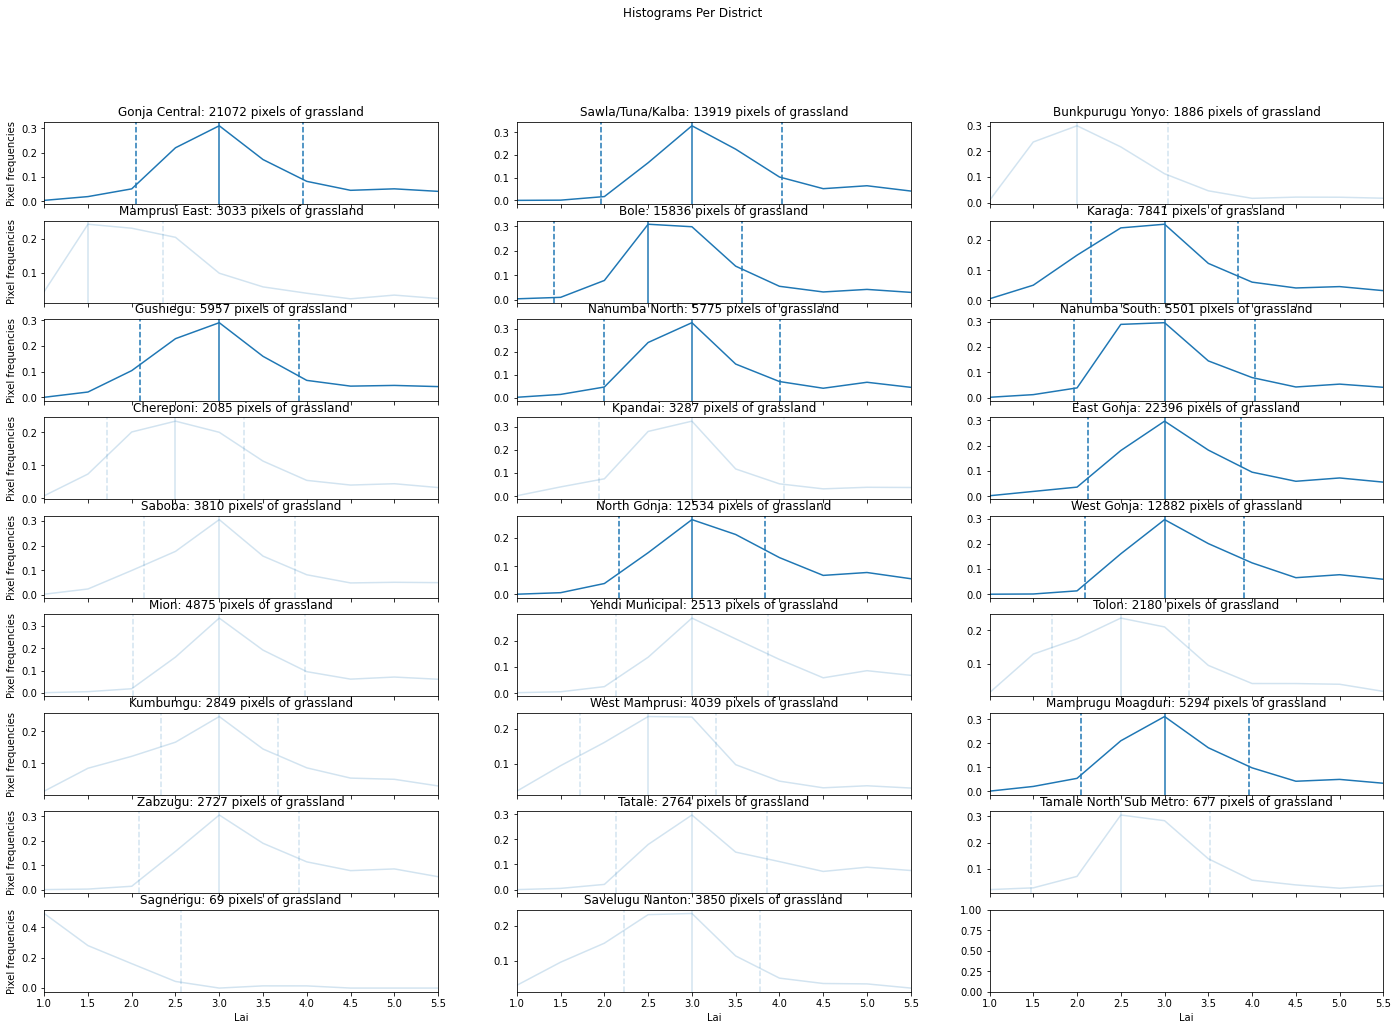

In [691]:
df_lai_params_2016 = histo_vi_per_district(2016, 'Lai', northern_district, \
                                            TIME_REDUCER='max',\
                                            CROPLAND_ONLY=True, ADD_TO_MAP=True, VERBOSE=True)
#Map

# The following plots shows the histograms (spatial median) of MAX Lai of all cropland pixels within each district, each curve per year from 2006 to 2018

In [14]:
fig, axes = plt.subplots(math.ceil(26 / 3),3, figsize=(24,16), sharex=True, sharey=False)
fig.suptitle(f'Histograms Per District')
plt.setp(axes[-1, :], xlabel='Lai')
plt.setp(axes[:, 0], ylabel='Pixel frequencies') # not intergers due to rescaled to 500m. counts intersects
axes= axes.flatten()

df_lai_model_params = pd.DataFrame(columns=['DISTRICT','YEAR', 'MAX_HISTO_FREQ', 'MAXLAI_PEAK', 'LAI_STDEV','LAI_CV'])
    
for year in range(MIN_YEAR, END_YEAR+1):
    df_lai_params = histo_vi_per_district(year, 'Lai', northern_district, \
                                    TIME_REDUCER='max',\
                                    CROPLAND_ONLY=True, ADD_TO_MAP=False, axes=axes)
    #print(df_lai_params.head())
    df_lai_model_params = df_lai_model_params.append(df_lai_params)

print(df_lai_model_params.head())

MODIS Lai and mean both SUCCESS for 2006
MODIS LC_Type2 and mean both SUCCESS for 2006
MODIS Lai and mean both SUCCESS for 2007
MODIS LC_Type2 and mean both SUCCESS for 2007
MODIS Lai and mean both SUCCESS for 2008
MODIS LC_Type2 and mean both SUCCESS for 2008
MODIS Lai and mean both SUCCESS for 2009
MODIS LC_Type2 and mean both SUCCESS for 2009
MODIS Lai and mean both SUCCESS for 2010
MODIS LC_Type2 and mean both SUCCESS for 2010
MODIS Lai and mean both SUCCESS for 2011
MODIS LC_Type2 and mean both SUCCESS for 2011
MODIS Lai and mean both SUCCESS for 2012
MODIS LC_Type2 and mean both SUCCESS for 2012
MODIS Lai and mean both SUCCESS for 2013
MODIS LC_Type2 and mean both SUCCESS for 2013
MODIS Lai and mean both SUCCESS for 2014
MODIS LC_Type2 and mean both SUCCESS for 2014
MODIS Lai and mean both SUCCESS for 2015
MODIS LC_Type2 and mean both SUCCESS for 2015
MODIS Lai and mean both SUCCESS for 2016
MODIS LC_Type2 and mean both SUCCESS for 2016
MODIS Lai and mean both SUCCESS for 2017
MO

DISTRICT  YEAR  MAX_HISTO_FREQ  MAXLAI_PEAK    LAI_STDEV    LAI_CV
0     Gonja Central  2006        0.276359          3.0  1712.210453  0.903774
1  Sawla/Tuna/Kalba  2006        0.303468          3.0  1593.191503  1.052784
2  Bunkpurugu Yonyo  2006        0.323952          2.0   203.693630  1.024062
3     Mamprusi East  2006        0.239166          2.0   233.296230  0.751680
4              Bole  2006        0.375849          2.5  1369.056708  1.195417

In [15]:
print(df_lai_model_params.head())
print(df_lai_model_params['DISTRICT'].unique())

df_median_param = df_lai_model_params.groupby('DISTRICT').median()
print(df_median_param.head())

df_crop_area = pd.read_csv('crop_area-Jose.csv', dtype={'name_adm2': str, 'maiz_r': np.float64})
#print(df_crop_area)

df_maize5000 = df_crop_area[df_crop_area['maiz_r']>=5000]
print(df_maize5000)
print(df_maize5000['name_adm2'].unique())

df_effect_districts = pd.merge(df_maize5000, df_median_param, left_on='name_adm2', right_on='DISTRICT')
df_effect_districts = df_effect_districts.rename(columns={'name_adm2':'DISTRICT'})
print(df_effect_districts)

           DISTRICT  YEAR  MAX_HISTO_FREQ  MAXLAI_PEAK    LAI_STDEV    LAI_CV
0     Gonja Central  2006        0.276359          3.0  1712.210453  0.903774
1  Sawla/Tuna/Kalba  2006        0.303468          3.0  1593.191503  1.052784
2  Bunkpurugu Yonyo  2006        0.323952          2.0   203.693630  1.024062
3     Mamprusi East  2006        0.239166          2.0   233.296230  0.751680
4              Bole  2006        0.375849          2.5  1369.056708  1.195417
['Gonja Central' 'Sawla/Tuna/Kalba' 'Bunkpurugu Yonyo' 'Mamprusi East'
 'Bole' 'Karaga' 'Gushiegu' 'Nanumba North' 'Nanumba South' 'Chereponi'
 'Kpandai' 'East Gonja' 'Saboba' 'North Gonja' 'West Gonja' 'Mion'
 'Yendi Municipal' 'Tolon' 'Kumbumgu' 'West Mamprusi' 'Mamprugu Moagduri'
 'Zabzugu' 'Tatale' 'Tamale North Sub Metro' 'Sagnerigu' 'Savelugu Nanton']
                  MAX_HISTO_FREQ  MAXLAI_PEAK    LAI_STDEV    LAI_CV
DISTRICT                                                            
Bole                    0.317244  

Now we have removed districts with not much maize (<5000), let's try regression on the rest of 13 district with at least 5000 unit area (?) of maize

In [16]:
print(df_northern_maize)

NameError: name 'df_northern_maize' is not defined

In [17]:
df_effective_maize = df_northern_maize.merge(df_effect_districts, how='inner')
print(df_effective_maize)

NameError: name 'df_northern_maize' is not defined

In [18]:
era5_bands = ['temperature_2m', 'total_precipitation', 'evaporation_from_bare_soil']

linreg_era5_with_yield_overall(df_effective_maize, era5_bands, VERBOSE=True)

NameError: name 'linreg_era5_with_yield_overall' is not defined

In [19]:
df_lai = pd.DataFrame(max_MODIS_LAIs, columns=range(MIN_YEAR,END_YEAR+1))
#df_lai.head()
df_lai.insert(0, 'DISTRICT', GAUL_district_names)
df_lai = df_lai.melt(id_vars=['DISTRICT']).rename(\
                columns={'variable':'YEAR','value':'MaxLAI'})
print(f'{df_lai.size} samples found in MODIS Max LAI record')

'''ADDING 4 LAI HISTO PARAMETERS '''
df_histo = df_effective_maize[['DISTRICT', 'MAX_HISTO_FREQ', 'MAXLAI_PEAK', 'LAI_STDEV', 'LAI_CV']]
df_lai = df_lai.merge(df_histo, how='left', on='DISTRICT')
 
print(df_lai.head(5))

NameError: name 'max_MODIS_LAIs' is not defined

In [473]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [20]:
def generate_era5_and_yield_DF(df_northern_maize, era5_bands, INCLUDE_LAI=True, VERBOSE=False):
    '''Make a DF of dependent variable, YIELD
    ATTENTION: max_MODIS_LAIs and GAUL_district_names are GLOBAL VARIABLES'''
    
    df_yield = df_northern_maize[['DISTRICT', 'YEAR', 'YIELD']]
    print(f'{df_yield.size} yield samples found in MOFA record')
    if VERBOSE: print(df_yield.head(5))
                            
    if INCLUDE_LAI:
        '''Make a DF of MAXLai data'''
        df_lai = pd.DataFrame(max_MODIS_LAIs, columns=range(MIN_YEAR,END_YEAR+1))
        #df_lai.head()
        df_lai.insert(0, 'DISTRICT', GAUL_district_names)
        df_lai = df_lai.melt(id_vars=['DISTRICT']).rename(\
                        columns={'variable':'YEAR','value':'MaxLAI'})
        print(f'{df_lai.size} samples found in MODIS Max LAI record')
        
        '''ADDING 4 LAI HISTO PARAMETERS '''
        df_histo = df_northern_maize[['DISTRICT', 'MAX_HISTO_FREQ', 'MAXLAI_PEAK', 'LAI_STDEV', 'LAI_CV']]
        df_lai = df_lai.merge(df_histo, how='left', on='DISTRICT')
        if VERBOSE: 
            print('*************TEST LAI HISTO PARAMS')
            print(df_lai.head(5))
    
    '''Make a DF of ERA5 data'''
    for i, era5_band in enumerate(era5_bands):
        print(f'Retreiving ERA5 monthly {era5_band}...')
        weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                            northern_district, band=era5_band, CROPONLY=True)
        if VERBOSE: print(weather_district.size, weather_ts.size, len(weather_ts))

        df_weather = pd.DataFrame(weather_ts, columns=range(MIN_YEAR,END_YEAR+1))
        df_weather.insert(0, 'DISTRICT', weather_district)
        #print(df_weather.head())

        df_weather = df_weather.melt(id_vars=['DISTRICT']).rename(\
                        columns={'variable':'YEAR','value':era5_band})
        #print(df_weather.head(50))

        if i == 0:
            df_era5 = df_weather
        else:
            df_era5 = df_era5.merge(df_weather, on=["DISTRICT", "YEAR"])
            #print(df_output.head(50))
        
    '''Merge LAI and ERA5 DFs'''
    if INCLUDE_LAI: 
        df_indp = df_era5.merge(df_lai, on=["DISTRICT", "YEAR"]) 
    else:
        df_indp = df_era5
    print(f'{df_indp.size} matching samples found in ERA5 record')
    if VERBOSE: print(df_indp.head())

    if df_indp.size > 0:
        df_yield = df_yield.merge(df_indp, on=["DISTRICT", "YEAR"])
        #print(df_yield.head)
        #df_yield = df_yield[['DISTRICT', 'YEAR', 'YIELD']]
        print(f'{df_yield.size} matching yield samples found')
        if VERBOSE: print(df_yield.head)
        
        if df_yield.size >0:
            
            # denpendent variable should be MOFA Yield
            if INCLUDE_LAI: 
                era5_bands.append('MaxLAI')
                '''ADDING 4 LAI HISTO PARAMETERS '''
                era5_bands.append('MAX_HISTO_FREQ')
                era5_bands.append('MAXLAI_PEAK')
                era5_bands.append('LAI_STDEV')
                era5_bands.append('LAI_CV')
            print('Indepedent variables are:', era5_bands)
            df_inp = df_yield[era5_bands]            
            return df_inp, df_yield['YIELD']        
        else: 
            print(f'Not enough YIELD data')
            return df_inp, pd.DataFrame() #return an empty DF
    else: 
        print(f'Not enough ERA5 data')
        return pd.DataFrame(), pd.DataFrame() #return two empty DFs

In [21]:
era5_bands = ['temperature_2m', 'total_precipitation', 'evaporation_from_bare_soil']
df_inp, df_yield = generate_era5_and_yield_DF(df_effective_maize, era5_bands, INCLUDE_LAI=True, VERBOSE=True)

NameError: name 'df_effective_maize' is not defined

In [22]:
df_inp

NameError: name 'df_inp' is not defined

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [24]:
# THIS BLOCK DEFINES A FEW BASIC MODELING PLOTTING FUNCTIONS
# plot the dataset and the model's line of best fit
def return_best_fit(X, y, xaxis, model, name, VERBOSE=False):
    #print(f'Fitting {name} model')
    # fit the model on input data
    model.fit(X, y)
    # calculate outputs for grid across the domain
    yaxis = model.predict(xaxis)
    scores = r2_score(y, yaxis)
    if VERBOSE: 
        print(f'>{name} Calibration accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})')
    return yaxis, np.mean(scores)
    
def evalute_model(X, y, model, name, VERBOSE=False):
    # define model evaluation method
    cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = np.absolute(scores)
    # summarize progress
    if VERBOSE: 
        print(f'>{name} Validation accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})')
    
    return np.mean(scores)
 
def plot_best_fit(plt_axis, X, y, model, name, test_size=0.40, VERBOSE=False):
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=test_size, random_state=1) 

    Yaxis, cal_score = return_best_fit(X_train, Y_train, X_train, model, name, VERBOSE=VERBOSE)    
    
    val_score = evalute_model(X, y, model, name, VERBOSE=VERBOSE)
    txt = f'{name} (Cal R2={cal_score:.2f}, Val R2={val_score:.2f})'
    
    plt_axis.plot(Y_train, Yaxis, '*', label= txt, alpha=max(0.1, cal_score))
    plt_axis.legend()
        
    #print(f'Intercept = {model.intercept_}, Coefficients: {model.coef_}')
    if VERBOSE: 
        print(f'{name} model MSE: {mean_squared_error(Y_train, Yaxis):.2f}')
        #print(f'Cal R2: {cal_score:.2f}, Val R2: {val_score:.2f}')
        
'''Next two functions are for testing MLP models'''
def MLP_fit_model(X_train, Y_train, name, model, VERBOSE=False):
    #print(f'Fitting {name} model: ')

    #plot_best_fit(axs[2], X_train, Y_train, X_train, model) 
    model.fit(X_train, Y_train)
    mlp_score = model.score(X_train, Y_train) #(X,y)  # OR X_TRAIN????
    # calculate outputs for grid across the domain
    yaxis = model.predict(X_train)

    r2scores = r2_score(Y_train, yaxis) 
    cal_score = np.mean(r2scores) # THIS SHOULD EQUAL MLP_SCORE
    #print(f'Intercept = {model.intercept_}, Coefficients: {model.coef_}')
    if VERBOSE: 
        print(f'>{name} Calibration accuracy: {cal_score:.2f} ({np.std(r2scores):.3f})')
    return cal_score, yaxis

def plot_MLP_fit(plt_axis, X, y, name, model, test_size=0.40, VERBOSE=False):
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=test_size, random_state=1) 
    cal_score, yaxis = MLP_fit_model(X_train, Y_train, name, model, VERBOSE=VERBOSE)
                    
    # evaluate/validate the model
    val_score = evalute_model(X, y, model, name)

    # plot the line of best fit
    txt = f'{name} (c={cal_score:.2f}, v={val_score:.2f})' #f'{name} (Cal R2={cal_score:.2f}, Val R2={val_score:.2f})'
    plt_axis.plot(Y_train, yaxis, '*', label= txt, alpha=max(0.1, cal_score))
    plt_axis.legend()

    if VERBOSE: 
        print(f'{name} model MSE: {mean_squared_error(Y_train, yaxis):.2f}')
    return cal_score

In [25]:

def ML_era5_with_yield_overall(df_inp, df_yield, era5_bands, test_size=0.40, \
                               INCLUDE_LAI=True, VERBOSE=False):
    
    assert not(df_inp.empty), 'Empty indepedent dataframe returned'
    assert not(df_yield.empty), 'Empty yield dataframe returned'
        
    # Split-out validation dataset        
    X = df_inp.values
    y = df_yield.values
    '''SPLIT NOW IS DONE IN plot_MLP_FIT FUNCTION
    #X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=test_size, random_state=1) 
    '''

    fig, axs = plt.subplots(5,3,figsize=(18,24))
    axs = axs.flatten()
        
    # linear models
    linear_models = []       
    linear_models.append(('Linear', LinearRegression()))
    linear_models.append(('Huber', HuberRegressor())) #predicts same value, why?
    linear_models.append(('RANSAC', RANSACRegressor()))
    linear_models.append(('TheilSen', TheilSenRegressor()))

    # non-linear models
    en_models = []
    en_models.append(('RF', RandomForestRegressor())) 
    en_models.append(('Boosting', GradientBoostingRegressor())) 
    en_models.append(('Bagging', BaggingRegressor()))
    #en_models.append(('SVC', SVC(kernel='poly'))) 
    en_models.append(('DecisionTree', DecisionTreeRegressor()))
          
    axs[0].set_title(f'Linear model performances, Test size {test_size:.2f}')
    for name, model in linear_models:
        plot_best_fit(axs[0], X, y, model, name)

    axs[1].set_title(f'Ensemble model performances, Test size {test_size:.2f}')
    for name, model in en_models:
        plot_best_fit(axs[1], X, y, model, name)    

    # MLP models
    mlp_activate = ['logistic', 'identity', 'tanh', 'relu']
    mlp_solver = ['lbfgs', 'sgd', 'adam']
    for i, act in enumerate(mlp_activate):
        for j, sol in enumerate(mlp_solver):
            axs[3+i*len(mlp_solver)+j].set_title(f'MLP {act} {sol} performances, Test size {test_size:.2f}')
    
            for layer1 in range(5,10,2):
                for layer2 in range(5,7,1):
                    name = f'{sol}-{layer1}-{layer2}'
                    model = make_pipeline(StandardScaler(), \
                                MLPRegressor(hidden_layer_sizes=(layer1,layer2), \
                                             tol=1e-2, random_state=1, \
                                             activation=act, solver=sol),)
            
                    plot_MLP_fit(axs[3+i*len(mlp_solver)+j], X, y, name, model, VERBOSE=VERBOSE)
                    

In [26]:
ML_era5_with_yield_overall(df_inp, df_yield, era5_bands, test_size=0.2)

NameError: name 'df_inp' is not defined

Based on above experiments, only **'lbfgs'** solver and 'relu' or 'tanh' activations will be used.

In [27]:
def MLP_era5_with_yield_overall(df_inp, df_yield, era5_bands, test_size=0.40, \
                               INCLUDE_LAI=True, VERBOSE=False):
    
    assert not(df_inp.empty), 'Empty indepedent dataframe returned'
    assert not(df_yield.empty), 'Empty yield dataframe returned'
        
    # Split-out validation dataset        
    X = df_inp.values
    y = df_yield.values
    
    fig, axs = plt.subplots(11,2,figsize=(18,24))

    # MLP 'lbfgs' models
    mlp_activate = ['tanh', 'relu']
    mlp_solver = ['lbfgs']
    for i, act in enumerate(mlp_activate):
        for j, sol in enumerate(mlp_solver):
            
            for l,layer1 in enumerate(range(9,100,9)):
                
                #idx = j*len(range(9,100,5))-1 + l
                axs[l, i].set_title(f'MLP {act} {sol} performances, Test size {test_size:.2f}')
    
                for layer2 in range(2,50,7):
                    name = f'{act}-{layer1}-{layer2}'
                    model = make_pipeline(StandardScaler(), \
                                MLPRegressor(hidden_layer_sizes=(layer1,layer2), \
                                             tol=1e-2, random_state=1, \
                                             activation=act, solver=sol),)
            
                    plot_MLP_fit(axs[l,i], X, y, name, model, test_size=test_size, VERBOSE=VERBOSE)  

In [28]:
MLP_era5_with_yield_overall(df_inp, df_yield, era5_bands, INCLUDE_LAI=True, VERBOSE=False) 

NameError: name 'df_inp' is not defined

In [29]:
def MLP_Contour_era5_with_yield_overall(df_inp, df_yield, era5_bands, test_size=0.40, \
                               INCLUDE_LAI=True, VERBOSE=False):
    
    assert not(df_inp.empty), 'Empty indepedent dataframe returned'
    assert not(df_yield.empty), 'Empty yield dataframe returned'
        
    # Split-out validation dataset        
    X = df_inp.values
    y = df_yield.values
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=test_size, random_state=1) 

    
    # MLP 'lbfgs'+'relu' models
    x_axis = range(1,200,5)
    y_axis = range(1,200,5)
    cal_scores = np.zeros(( len(y_axis), len(x_axis)))
    
    for l,layer1 in enumerate(x_axis):
        for m,layer2 in enumerate(y_axis):
            name = f'relu-{layer1}-{layer2}'
            model = make_pipeline(StandardScaler(), \
                        MLPRegressor(hidden_layer_sizes=(layer1,layer2), \
                                     tol=1e-2, random_state=1, \
                                     activation='relu', solver='lbfgs'),)
            
            cal_score, yaxis = MLP_fit_model(X_train, Y_train, name, model, VERBOSE=VERBOSE)
            val_score = evalute_model(X_validation, Y_validation, model, name)
            cal_scores[m,l] = cal_score 
            
    cp = plt.contourf(x_axis, y_axis, cal_scores)
    row = cal_scores.argmax() // len(x_axis)
    col= cal_scores.argmax() % len(x_axis)
    plt.colorbar(cp)
    plt.plot(x_axis[col], y_axis[row], 'ro')
    plt.title(f'Relu lbfgs error surface with best fit of {cal_scores.max():.3f} (at layer1={x_axis[col]},layer2={y_axis[row]})')

    return x_axis[col], y_axis[row], cal_scores

In [30]:
x_col, y_row, cal_scores = MLP_Contour_era5_with_yield_overall(df_inp, df_yield, era5_bands, INCLUDE_LAI=True) 

NameError: name 'df_inp' is not defined

In [31]:
x_axis = range(1,200,5)
y_axis = range(1,200,5)
cp = plt.contourf(x_axis, y_axis, cal_scores)
plt.colorbar(cp)
row = cal_scores.argmax() // len(x_axis)
col= cal_scores.argmax() % len(x_axis)
plt.plot(x_axis[col], y_axis[row], 'ro')
plt.title(f'Relu lbfgs error surface with best fit of {cal_scores.max():.3f} (at layer1={x_axis[col]},layer2={y_axis[row]})')


NameError: name 'cal_scores' is not defined

In [32]:
def MLP_fixed_era5_with_yield_overall(df_inp, df_yield, era5_bands, c=69, r=19, test_size=0.40, VERBOSE=False):
    
    assert not(df_inp.empty), 'Empty indepedent dataframe returned'
    assert not(df_yield.empty), 'Empty yield dataframe returned'
        
    # Split-out validation dataset        
    X = df_inp.values
    y = df_yield.values
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=test_size, random_state=1) 
    print(Y_train.mean(), Y_train.std())
    print('----------------')
    print(Y_validation.mean(), Y_validation.std())
    
    # MLP 'lbfgs'+'relu' models with fixed layers
    layer1 = c
    layer2 = r
    name = f'relu-{layer1}-{layer2}'
    model = make_pipeline(StandardScaler(), \
                MLPRegressor(hidden_layer_sizes=(layer1,layer2), \
                             tol=1e-2, random_state=1, \
                             activation='relu', solver='lbfgs'),)

    cal_score, yaxis = MLP_fit_model(X_train, Y_train, name, model, VERBOSE=VERBOSE)
    #val_score = evalute_model(X_validation, Y_validation, model, name)
    val_score = evalute_model(X, y, model, name)
            
    plt.plot(Y_train, yaxis, '*', label='Calibration')
    plt.title(f'Yield Prediction with Relu lbfgs model c={cal_score:.3f} cv={val_score:.3f}')
    
    Y_prediction = model.predict(X_validation)
    plt.plot(Y_validation, Y_prediction, 'o', mfc='none', label='Validation')
    plt.legend()
    plt.xlabel("MOFA Yield")
    plt.ylabel("Predicted yield")
    
MLP_fixed_era5_with_yield_overall(df_inp, df_yield, era5_bands, c=x_col, r=y_row, test_size=0.4) 

NameError: name 'df_inp' is not defined

# TO DO: 
Quantise histo and
Look at non-linear model per district, ML, Cal/val

In [33]:
#df_effective_maize = df_effective_maize.drop(columns=['REGION', 'CROP', 'SAVANNAH'])
df_effective_maize.head()
#df_effective_maize.groupby('YEAR').size()
df_effective_maize['YIELD'].plot(kind='box')

NameError: name 'df_effective_maize' is not defined

In [34]:
df_effect_districts.describe()

maiz_r  MAX_HISTO_FREQ  MAXLAI_PEAK    LAI_STDEV     LAI_CV
count     13.000000       13.000000    13.000000    13.000000  13.000000
mean    9755.523077        0.287937     2.884615   634.122345   0.915897
std     2725.307124        0.021012     0.219265   544.539714   0.084083
min     5951.600000        0.257636     2.500000    62.136038   0.800061
25%     8257.600000        0.269452     3.000000   251.252752   0.869817
50%     9768.000000        0.289124     3.000000   550.643432   0.894366
75%    10992.800000        0.306140     3.000000   750.921523   0.967261
max    16857.600000        0.320731     3.000000  1879.520712   1.083713

maiz_r               AxesSubplot(0.125,0.536818;0.227941x0.343182)
MAX_HISTO_FREQ    AxesSubplot(0.398529,0.536818;0.227941x0.343182)
MAXLAI_PEAK       AxesSubplot(0.672059,0.536818;0.227941x0.343182)
LAI_STDEV               AxesSubplot(0.125,0.125;0.227941x0.343182)
LAI_CV               AxesSubplot(0.398529,0.125;0.227941x0.343182)
dtype: object

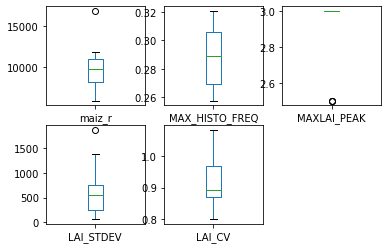

In [35]:
df_effect_districts.plot(kind='box', subplots=True, layout=(2,3))

In [36]:
df_effect_districts.hist()

array([[<AxesSubplot:title={'center':'maiz_r'}>,
        <AxesSubplot:title={'center':'MAX_HISTO_FREQ'}>],
       [<AxesSubplot:title={'center':'MAXLAI_PEAK'}>,
        <AxesSubplot:title={'center':'LAI_STDEV'}>],
       [<AxesSubplot:title={'center':'LAI_CV'}>, <AxesSubplot:>]],
      dtype=object)

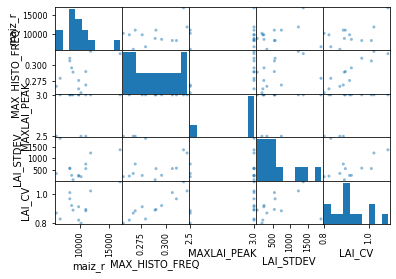

In [37]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_effect_districts)
plt.show()

In [38]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
y = array[:,4]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

NameError: name 'dataset' is not defined

In [39]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

NameError: name 'LogisticRegression' is not defined

In [40]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

NameError: name 'pyplot' is not defined

In [41]:
# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

NameError: name 'X_train' is not defined

# Nextly, simply plot LAI trajectories for each district (Under construction)

In [42]:
aoi = northern_district.first()
year = 2016 
lai_whole_year, mean = load_modis_band('Lai', year, aoi, 'None')

def district_image(image, aoi):
    stats = image.reduceRegion(reducer=ee.Reducer.mean(), \
                                geometry=aoi, scale=500, maxPixels= 1e10)
    return stats
    
timeSeries = lai_whole_year.map(lambda image: image.reduceRegions(collection=aoi, reducer=ee.Reducer.mean(), \
                                scale=500))
print(timeSeries.getInfo())

Returning MODIS Lai time series (no time-reducer)


EEException: Feature, argument 'geometry': Invalid type.
Expected type: Geometry.
Actual type: Feature.

### Repeat for multiple years (max anual LAI per distrct, all land cover or cropland only)

## Nextly, we calculate the max annual LAI per district for cropland areas only
TO DO: then consider QA mask too


In [43]:
'''THIS BLOCK CAN REPLACE THE ABOVE BLOCK OF FUNCTION modis_vi_per_district() BY SETTING CROP_ONLY=Flase'''
def modis_vi_per_district_cropmask(year, vi_band, aoi, TIME_REDUCER='max', SPACE_DERUCER='mean', \
                                   CROP_ONLY=True, ADD_TO_MAP=False):

    #Firstly, we calculate the mean VI (annual average VI) per district:
    vi_all, vi_annual_reduced = load_modis_band(vi_band, year, aoi, TIME_REDUCER)
    
    if CROP_ONLY:
        #we mask the VI images by LC type of croplands only
        lc_crop, lc_all = load_modis_lc('LC_Type2', year, aoi, cropclasses=[10]) 
        #print(lc_crop.getInfo())
        if ADD_TO_MAP:
            Map.addLayer(lc_crop, {'min':0, 'max':1}, f"Croplands {year}", opacity=0.7)
        
        '''mask croplands only'''  
        vi_annual_reduced = vi_annual_reduced.mask(lc_crop)
        
    if SPACE_DERUCER != 'None':
        space_methods = {'mean': ee.Reducer.mean, \
                   'max': ee.Reducer.max, \
                   'min': ee.Reducer.min,\
                   'median': ee.Reducer.median}
    
        if SPACE_DERUCER in space_methods:
            vi_per_district = vi_annual_reduced.reduceRegions(collection=aoi,\
                                                   reducer=space_methods[SPACE_DERUCER](),\
                                                   scale=500)
        else:
            raise Exception("Method %s not implemented" % SPACE_DERUCER)
        
    list_of_districts = vi_per_district.aggregate_array('ADM2_NAME').getInfo()
    list_of_meanVIs = vi_per_district.aggregate_array(SPACE_DERUCER).getInfo()
    
    if ADD_TO_MAP:
        Map.addLayer(vi_per_district, {'min': 0.0,'max': 2.5}, f'{SPACE_DERUCER} {vi_band} {year} per district (Cropland Only)')
    
    stats = vi_per_district.aggregate_stats('mean')
    print(year, vi_band, stats.getInfo()) 
    
    return np.asarray(list_of_districts), np.asarray(list_of_meanVIs)

In [44]:
modis_vi_per_district_cropmask(2019, 'Lai', northern_district, CROP_ONLY=True, ADD_TO_MAP=True)
#Map

MODIS Lai and mean both SUCCESS for 2019
MODIS LC_Type2 and mean both SUCCESS for 2019
2019 Lai {'max': 4.772523923764908, 'mean': 3.8860398528311633, 'min': 1.77802513464991, 'sample_sd': 0.6883412668691338, 'sample_var': 0.47381369967500403, 'sum': 101.03703617361025, 'sum_sq': 404.47929167446836, 'total_count': 26, 'total_sd': 0.6749741445724792, 'total_var': 0.45559009584135, 'valid_count': 26, 'weight_sum': 26, 'weighted_sum': 101.03703617361025}


(array(['Gonja Central', 'Sawla/Tuna/Kalba', 'Bunkpurugu Yonyo',
        'Mamprusi East', 'Bole', 'Karaga', 'Gushiegu', 'Nanumba North',
        'Nanumba South', 'Chereponi', 'Kpandai', 'East Gonja', 'Saboba',
        'North Gonja', 'West Gonja', 'Mion', 'Yendi Municipal', 'Tolon',
        'Kumbumgu', 'West Mamprusi', 'Mamprugu Moagduri', 'Zabzugu',
        'Tatale', 'Tamale North Sub Metro', 'Sagnerigu', 'Savelugu Nanton'],
       dtype='<U22'),
 array([4.42277943, 4.0201812 , 2.90817993, 3.00218879, 4.28541254,
        3.32523283, 3.54672166, 4.31757914, 4.61350931, 3.26442491,
        4.36007371, 4.71465774, 3.89639608, 4.23211393, 4.28044111,
        4.28799487, 4.39702203, 3.49567738, 3.87575057, 3.49539972,
        4.0031165 , 4.77252392, 4.68947285, 3.68170619, 1.77802513,
        3.3704547 ]))

In [45]:
def mean_ndvi_per_district(years, aoi, CROPONLY=False):
    for year in years: 
        #reduce to per district values (district_names should be constant over years)
        district_names, mean_VI_per_district = modis_annual_vi_per_district(year, 'NDVI', aoi, \
                                                                              CROP_ONLY=CROPONLY, ADD_TO_MAP=False)
        #print(type(mean_VI_per_district))
        if year == years[0]: 
            mean_ndvi = mean_VI_per_district
            #print(type(mean_ndvi), mean_ndvi.size)
        else: mean_ndvi = np.vstack((mean_ndvi, mean_VI_per_district))

    #print('No. of districts: ', len(district_names))
    #print('No. of years: ', len(mean_ndvi))
    #print(type(mean_ndvi), mean_ndvi.size, len(mean_ndvi))
    mean_ndvi = np.transpose(mean_ndvi)

    plt.figure(figsize=(16,12))

    for i, district in enumerate(district_names):
        plt.plot(years, mean_ndvi[i], label=district)
    if CROPONLY:
        plt.title('Average NDVI per district (Croplands only)')
    else: 
        plt.title('Average NDVI per district (all land covers)')
    plt.legend()  
    
    return district_names, mean_ndvi

In [46]:
def max_lai_per_district(years, aoi, CROPONLY=False):
    for year in years: 
        #reduce to per district values (district_names should be constant over years)
        district_names, reduced_VI_per_district = modis_annual_vi_per_district(year, 'Lai', aoi, \
                                                                    TIME_REDUCER='max', SPACE_DERUCER='mean',\
                                                                    CROP_ONLY=CROPONLY, ADD_TO_MAP=False)
        #print(type(mean_VI_per_district))
        if year == years[0]: 
            max_lai = reduced_VI_per_district
            #print(type(mean_ndvi), mean_ndvi.size)
        else: max_lai = np.vstack((max_lai, reduced_VI_per_district))

    max_lai = np.transpose(max_lai)

    plt.figure(figsize=(16,12))

    for i, district in enumerate(district_names):
        plt.plot(years, max_lai[i], label=district)
    if CROPONLY:
        plt.title('Max LAI per district (Croplands only)')
    else: 
        plt.title('Max LAI per district (all land covers)')
    plt.legend()  
    
    return district_names, max_lai

Next, examine the time series of croponly NDVI :

In [47]:
GAUL_district_names, max_MODIS_LAIs = max_lai_per_district(range(MIN_YEAR, END_YEAR+1), northern_district, CROPONLY=True)

TypeError: modis_annual_vi_per_district() got an unexpected keyword argument 'CROP_ONLY'

# Plot MOFA yield trends
Lewis: scope multiple years of MODIS LAI/NDVI relationship with yield (e.g. https://zenodo.org/record/3669955#.YPgzORNKh25)

## Data source: 
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229881
Ghana Yield per district 2006-2016 for four different crops; In this CSV file, several country names have been trimmed or split to match the GAUL county names and to match the 2016-2020 MAIZE yield data provided by Kofi from MOFA as well. These counties are:
'Bunkpurugu Yonyo', 'Savelugu Nanton', 'Saboba',
'Tolon' and 'Kumbungu' 
'Zabzugu' 'Tatale' 
'Kpandai' 'Chereponi'
 'Savelugu' 'Nanton' 

and **the final county-level yield from 2006 to 2020 was summarised into Ghana_Distirct_level_Crop_Yield_Data-upto2020_NORTHERN-ONLY.csv** file.

In [4]:
df = pd.read_csv('Ghana_Distirct_level_Crop_Yield_Data-upto2018_NORTHERN-ONLY.csv', sep=',', header=0)

print(df.info())

print(df['REGION'].unique())
print(df['CROP'].unique())

df = df.replace('Groundnut', 'GROUNDNUT')
df = df.replace('NORTHERN ', 'NORTHERN')
df = df.replace('  COWPEA', 'Cowpea')

print(df['REGION'].unique())
print(df['CROP'].unique())

# fix MOFA district names to match with GUAL and ERA5 district names
#if ('Gonja' in district) or ('East Mamprusi' in district): district = rev_sentence(district)
df = df.replace('Central Gonja','Gonja Central')
df = df.replace('East Mamprusi','Mamprusi East')

df = df.replace('Tamale Metro','Tamale North Sub Metro')
df = df.replace('Yendi','Yendi Municipal')

df_northern_maize = df[(df['CROP']=='MAIZE') & (df['REGION']=='NORTHERN')] 
df_northern_maize

print(df_northern_maize['DISTRICT'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REGION    732 non-null    object 
 1   DISTRICT  732 non-null    object 
 2   YEAR      732 non-null    int64  
 3   CROP      732 non-null    object 
 4   YIELD     732 non-null    float64
 5   SAVANNAH  12 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 34.4+ KB
None
['NORTHERN' 'NORTHERN ']
['Groundnut' 'Cowpea' 'MAIZE' 'GROUNDNUT' '  COWPEA']
['NORTHERN']
['GROUNDNUT' 'Cowpea' 'MAIZE']
['Gonja Central' 'West Gonja' 'Yendi Municipal' 'Nanumba North'
 'Nanumba South' 'Karaga' 'Gushiegu' 'Bunkpurugu Yonyo' 'Mamprusi East'
 'Savelugu Nanton' 'East Gonja' 'Tamale North Sub Metro'
 'Sawla/Tuna/Kalba' 'Bole' 'Saboba' 'Tolon' 'Kumbungu' 'West Mamprusi'
 'Zabzugu' 'Tatale' 'Kpandai' 'Chereponi' 'Sagnerigu' 'Mion' 'North Gonja']


In [43]:
northern_districts = df_northern_maize['DISTRICT'].unique()
print(len(northern_districts))

plt.figure(figsize=(16,12))

for district in northern_districts:
    df_district = df_northern_maize[df_northern_maize['DISTRICT']==district]
    plt.plot(df_district['YEAR'], df_district['YIELD'], label=district)
plt.title('MOFA Maize Yield Time Series (per district)')
plt.legend()

25


# Plot two data together

In [44]:
# swap word order to match with 'ADM2_NAME'
def rev_sentence(sentence): 
    words = sentence.split(' ') 
    reverse_sentence = ' '.join(reversed(words)) 
    return reverse_sentence 
#print(f'District name "{rev_sentence(district)}" changed into "{district}"')

In [45]:
def plot_gee_series_vs_mofa_yield(gee_district_names, gee_data, df_mofa, crops=['MAIZE'],\
                                  series_name = 'MODIS VI', \
                                  USE_REGIONAL_MEAN=True, VERBOSE=False):
    mofa_districts = df_mofa['DISTRICT'].unique()
    if VERBOSE:
        print(len(mofa_districts), 'unique districts found in MOFA data.')
        print(mofa_districts)
        print(len(gee_district_names), 'unique districts found in GEE data.')
        print(gee_district_names)
        print(len(gee_data), len(gee_data[0]))
    
    fig, axes = plt.subplots(math.ceil(len(mofa_districts) / 3),3, figsize=(24,16), sharex=True, sharey=True)
    axes= axes.flatten()
    
    ith = 0
    
    for i, district in enumerate(mofa_districts):
        
        df_district = df_mofa[df_mofa['DISTRICT']==district]
            
        ax1 = axes[i]
        ax2 = ax1.twinx()
    
        for crop in crops:
            df_mofa_maize = df_district[(df_district['CROP']==crop)].sort_values('YEAR')            
            r = 0.
            
            years = df_mofa_maize['YEAR'].to_numpy(dtype=int)
            if VERBOSE: 
                if VERBOSE: 
                    print(district, len(years), years)
            
            # find the same district in MODIS NDVI
            if (district in gee_district_names):
                if VERBOSE: 
                    print(i, ith, district)
                district_data = gee_data[i]
                #if VERBOSE: print('Length of district_data',len(district_data))
                series_condition = ''
                linestyle = '-.'
                ith = ith+1
            elif USE_REGIONAL_MEAN:
                if VERBOSE: 
                    print(district, ' USING REGINAL MEAN')
                district_data = gee_data.mean(axis=0) #regional mean per year
                series_condition = ' (Regional average)'
                linestyle = ':'
            else:
                district_data = np.empty(1)
                
            #print(len(district_data), len(years))
            if len(years) == 0:
                print(district,' does not have MOFA data')
            elif len(years) == len(district_data):
                x = years
                r = np.corrcoef(district_data, df_mofa_maize['YIELD'])[0,1]
                if VERBOSE: 
                    print('r=', r)
                    #print(district_data, '\n', df_mofa_maize['YIELD'])
            else: 
                x = range(MIN_YEAR, END_YEAR+1)
                relation_len = len(years)
                if years[0] == x[0]: #when MOFA data start from 2006, but short in length when compared to GEE data
                    r = np.corrcoef(district_data[:relation_len], df_mofa_maize['YIELD'])[0,1]
                elif years[-1] == x[-1]:
                    r = np.corrcoef(district_data[-relation_len:], df_mofa_maize['YIELD'])[0,1]
                
            if (crop==crops[0]) and (len(district_data)>1):
                ax1.plot(x, district_data, linestyle, label=series_name+series_condition)
                ax1.legend(loc=2, fontsize='small')
            
                
            ax2.plot(years, df_mofa_maize['YIELD'], label=f'{crop} Yield R2={r*r:{".5f" if r != 0 else "0"}}') #color=ax1.lines[-1].get_color()            
            ax2.legend(loc=3, fontsize='small')
        axes[i].title.set_text(f'{district}') #R2={r*r:.5f}
        
    plt.suptitle(f'{series_name} vs MOFA {crops} Yield (per district)')

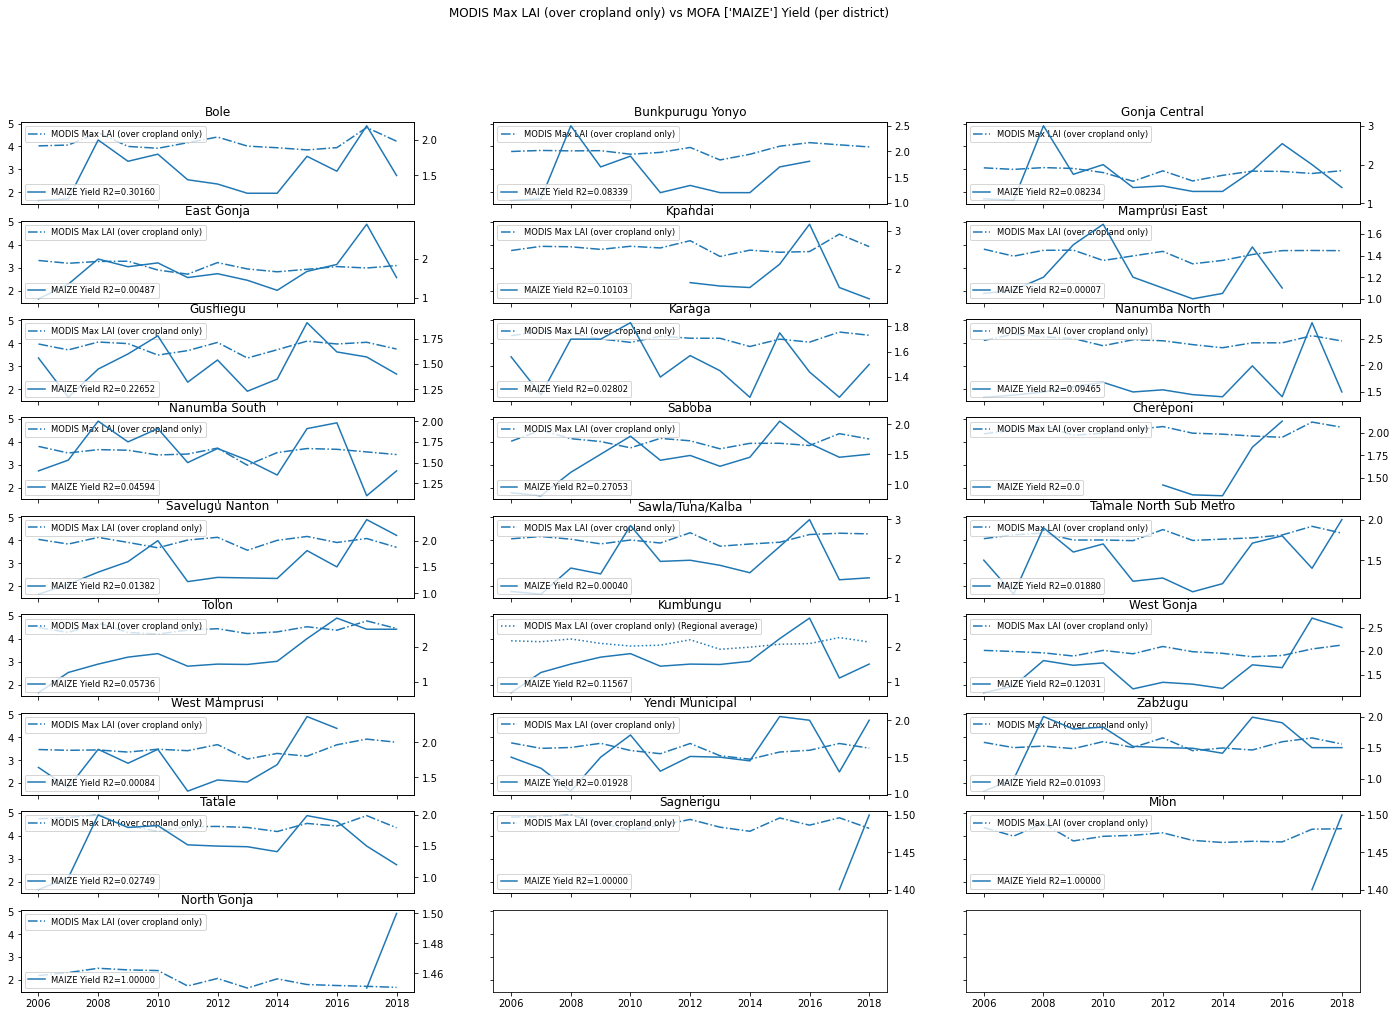

In [46]:
plot_gee_series_vs_mofa_yield(GAUL_district_names, max_MODIS_LAIs, df[df['REGION']=='NORTHERN'], crops=['MAIZE'],
                             series_name = 'MODIS Max LAI (over cropland only)', VERBOSE=False)

Groundnut growing season: starting April/May and ending in September/October, so can use the same seasonal range

Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data


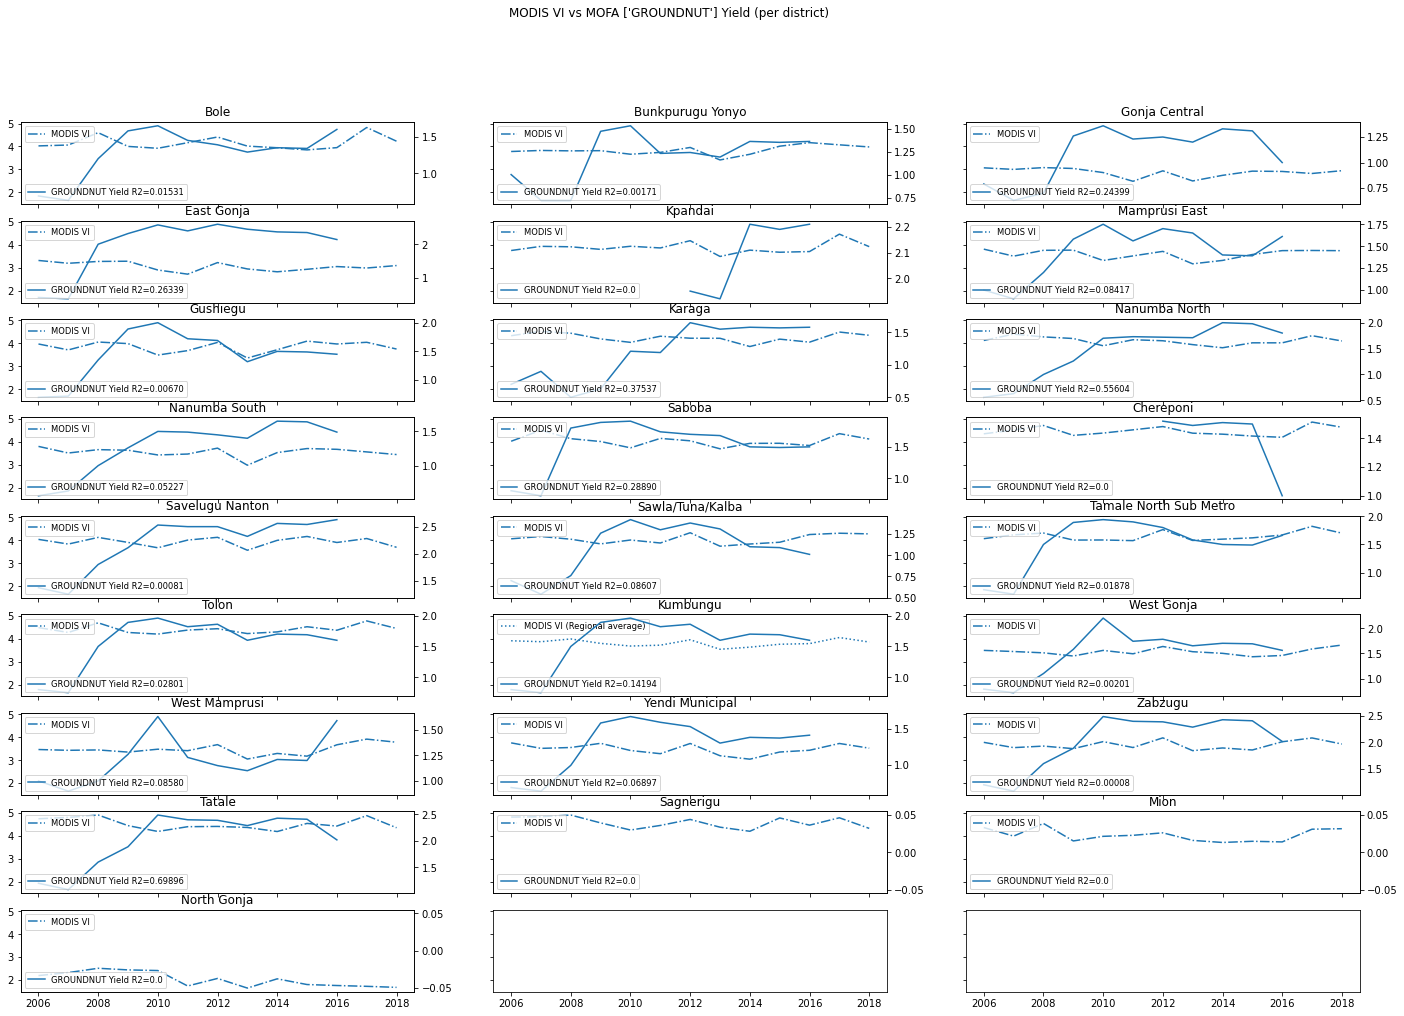

In [47]:
plot_gee_series_vs_mofa_yield(GAUL_district_names, max_MODIS_LAIs, df[df['REGION']=='NORTHERN'], \
                              crops=['GROUNDNUT'])

Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data


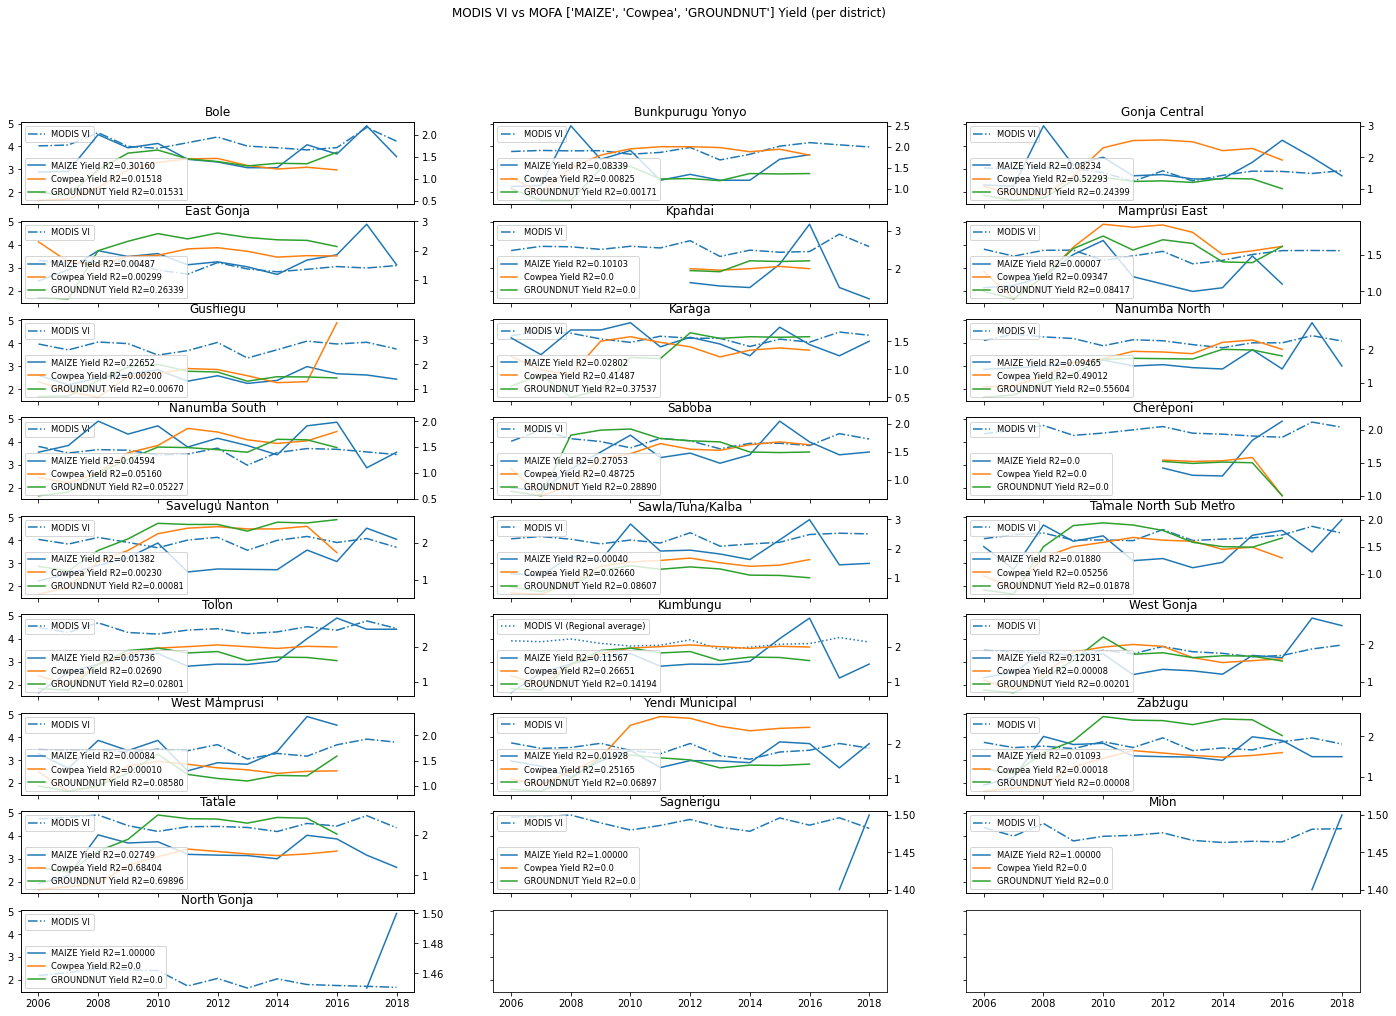

In [48]:
plot_gee_series_vs_mofa_yield(GAUL_district_names, max_MODIS_LAIs, \
                              df[df['REGION']=='NORTHERN'], crops=['MAIZE','Cowpea','GROUNDNUT'])

So far, we have plotted the **annual max LAI** against yield. nextly, we need to know the **crop calender** (so amount of rainfall, soil moisture, temperature in the district), and see how much meteology is explaining the variation? ALSO modis FaPAR until 2020 is availible for the hole country.

So, exploratory analysis at district level, with **crop/non-crop mask**.

**multi-linear regression** to test explanatory powers of above factors, against yield. 

Also, refine scale?

## Adding Climate data 
Monthly [ERA5 2m temperature](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY) is used here. It comes in a '0.1 arc degrees' resolution.

infor on crop calender of diff crops :
    https://cropcalendar.apps.fao.org/#/home 
        e.g. cumulated rainful 

In [49]:
era5_visualization = {
  'bands': ['temperature_2m'],
  'min': 298.0, 
  'max': 315.0,
  'palette': [
    "#000080","#0000D9","#4000FF","#8000FF","#0080FF","#00FFFF",
    "#00FF80","#80FF00","#DAFF00","#FFFF00","#FFF500","#FFDA00",
    "#FFB000","#FFA400","#FF4F00","#FF2500","#FF0A00","#FF00FF",
  ]
}

In [50]:
def load_era_band(band, year, aoi, ADD_TO_MAP=False, VERBOSE=False):
    weather_in_season = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")\
            .filterBounds(aoi) \
            .select(band)\
            .filterDate(f'{year}-06-01', f'{year}-10-31') #only during MAize crop season
    size = weather_in_season.size()
    if VERBOSE:
        print(f'In {year}, {size.getInfo()} image(s) found.')
    
    if ADD_TO_MAP:
        Map.addLayer(weather_in_season, era5_visualization, "Air temperature [K] at 2m height")
    return weather_in_season

In [51]:
weather2016 = load_era_band('temperature_2m', 2016, northern_district, VERBOSE=True)
#print(weather2016.getInfo())

In 2016, 5 image(s) found.


In [52]:
def era4_value_per_district(year, aoi, band='temperature_2m', \
                            VERBOSE=False, ADD_TO_MAP=False):
    era5_in_season = load_era_band(band, year, aoi)
    era5_seasonal_accum = era5_in_season.sum()
    
    accum_per_district = era5_seasonal_accum.reduceRegions(collection=aoi,\
                                                   reducer=ee.Reducer.mean(),\
                                                    scale=11.1*1000) # ERA5 resoltuion = 0.1 deg
    
    #print('------', accum_per_district.getInfo()) # this should be a 'FeatureCollection'
    list_of_districts = accum_per_district.aggregate_array('ADM2_NAME').getInfo()
    if VERBOSE:
        print(len(list_of_districts), list_of_districts) # this line prints all district names
    
    list_of_means = accum_per_district.aggregate_array('mean').getInfo()
    if VERBOSE:
        print(len(list_of_means), list_of_means) # this line prints all mean values
    
    if ADD_TO_MAP :
        Map.addLayer(accum_per_district, {'min': 0.0,'max': 300*5}, f'Mean {band} {year} per district')
    
    stats = accum_per_district.aggregate_stats('mean')
    if VERBOSE:
        print(year, band, stats.getInfo()) 
    
    return np.asarray(list_of_districts), np.asarray(list_of_means)

In [53]:
weather_district, weather_2016 = era4_value_per_district(2016, northern_district, VERBOSE=True, ADD_TO_MAP=False)

26 ['Gonja Central', 'Sawla/Tuna/Kalba', 'Bunkpurugu Yonyo', 'Mamprusi East', 'Bole', 'Karaga', 'Gushiegu', 'Nanumba North', 'Nanumba South', 'Chereponi', 'Kpandai', 'East Gonja', 'Saboba', 'North Gonja', 'West Gonja', 'Mion', 'Yendi Municipal', 'Tolon', 'Kumbumgu', 'West Mamprusi', 'Mamprugu Moagduri', 'Zabzugu', 'Tatale', 'Tamale North Sub Metro', 'Sagnerigu', 'Savelugu Nanton']
26 [1498.9587764688479, 1495.9915992402352, 1498.720516510581, 1498.892660009049, 1496.7604736136993, 1499.7725636484706, 1498.4510332518673, 1494.6659187119376, 1494.1727593119676, 1499.8291676280835, 1494.3435308119829, 1497.5416807841027, 1498.7691686334647, 1498.1356882949456, 1497.5333170016868, 1496.5994857133453, 1496.992236987016, 1499.7140899317226, 1500.6010744347202, 1501.106303468833, 1501.636955030037, 1496.1400189356502, 1495.5209529393537, 1498.6830233640776, 1498.673012153252, 1499.9595932466843]
2016 temperature_2m {'max': 1501.636955030037, 'mean': 1498.0063692356007, 'min': 1494.17275931196

In [186]:
def era5_ts_per_district(years, aoi, band='temperature_2m', CROPONLY=False, PLOT=False): #resolution so low, no need for CROPONLY
    for year in years: 
        #reduce to per district values (district_names should be constant over years)
        district_names, mean_era5_per_district = era4_value_per_district(year, aoi, band, ADD_TO_MAP=False)
        #print(type(mean_era5_per_district))
        if year == years[0]: 
            mean_era5 = mean_era5_per_district
            #print(type(mean_ndvi), mean_ndvi.size)
        else: mean_era5 = np.vstack((mean_era5, mean_era5_per_district))

    #print('No. of districts: ', len(district_names), '; No. of years: ', len(mean_era5))
    #print(type(mean_ndvi), mean_ndvi.size, len(mean_ndvi))
    mean_era5 = np.transpose(mean_era5)

    if PLOT:
        plt.figure(figsize=(16,12))

        for i, district in enumerate(district_names):
            plt.plot(years, mean_era5[i], label=district)
        if CROPONLY:
            plt.title(f'Average {band} per district (Croplands only)')
        else: 
            plt.title(f'Average {band} per district (all land covers)')
        plt.legend()  
    
    return district_names, mean_era5

In [55]:
era5_ts_per_district([2018], northern_district, band='temperature_2m')

No. of districts:  26 ; No. of years:  26


(array(['Gonja Central', 'Sawla/Tuna/Kalba', 'Bunkpurugu Yonyo',
        'Mamprusi East', 'Bole', 'Karaga', 'Gushiegu', 'Nanumba North',
        'Nanumba South', 'Chereponi', 'Kpandai', 'East Gonja', 'Saboba',
        'North Gonja', 'West Gonja', 'Mion', 'Yendi Municipal', 'Tolon',
        'Kumbumgu', 'West Mamprusi', 'Mamprugu Moagduri', 'Zabzugu',
        'Tatale', 'Tamale North Sub Metro', 'Sagnerigu', 'Savelugu Nanton'],
       dtype='<U22'),
 array([1497.36030768, 1493.95820737, 1496.58186563, 1496.59982736,
        1494.91109051, 1497.74245498, 1496.46460882, 1493.93084645,
        1493.45461943, 1497.63248468, 1493.70529062, 1496.34718679,
        1496.8471494 , 1496.16384237, 1495.68214981, 1495.40825761,
        1495.6896853 , 1498.1932801 , 1498.80193023, 1499.02414812,
        1499.19128336, 1495.09721793, 1494.27898756, 1497.3943033 ,
        1497.33334934, 1498.14747408]))

In [56]:
weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), northern_district, band='temperature_2m')

No. of districts:  26 ; No. of years:  13


Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data


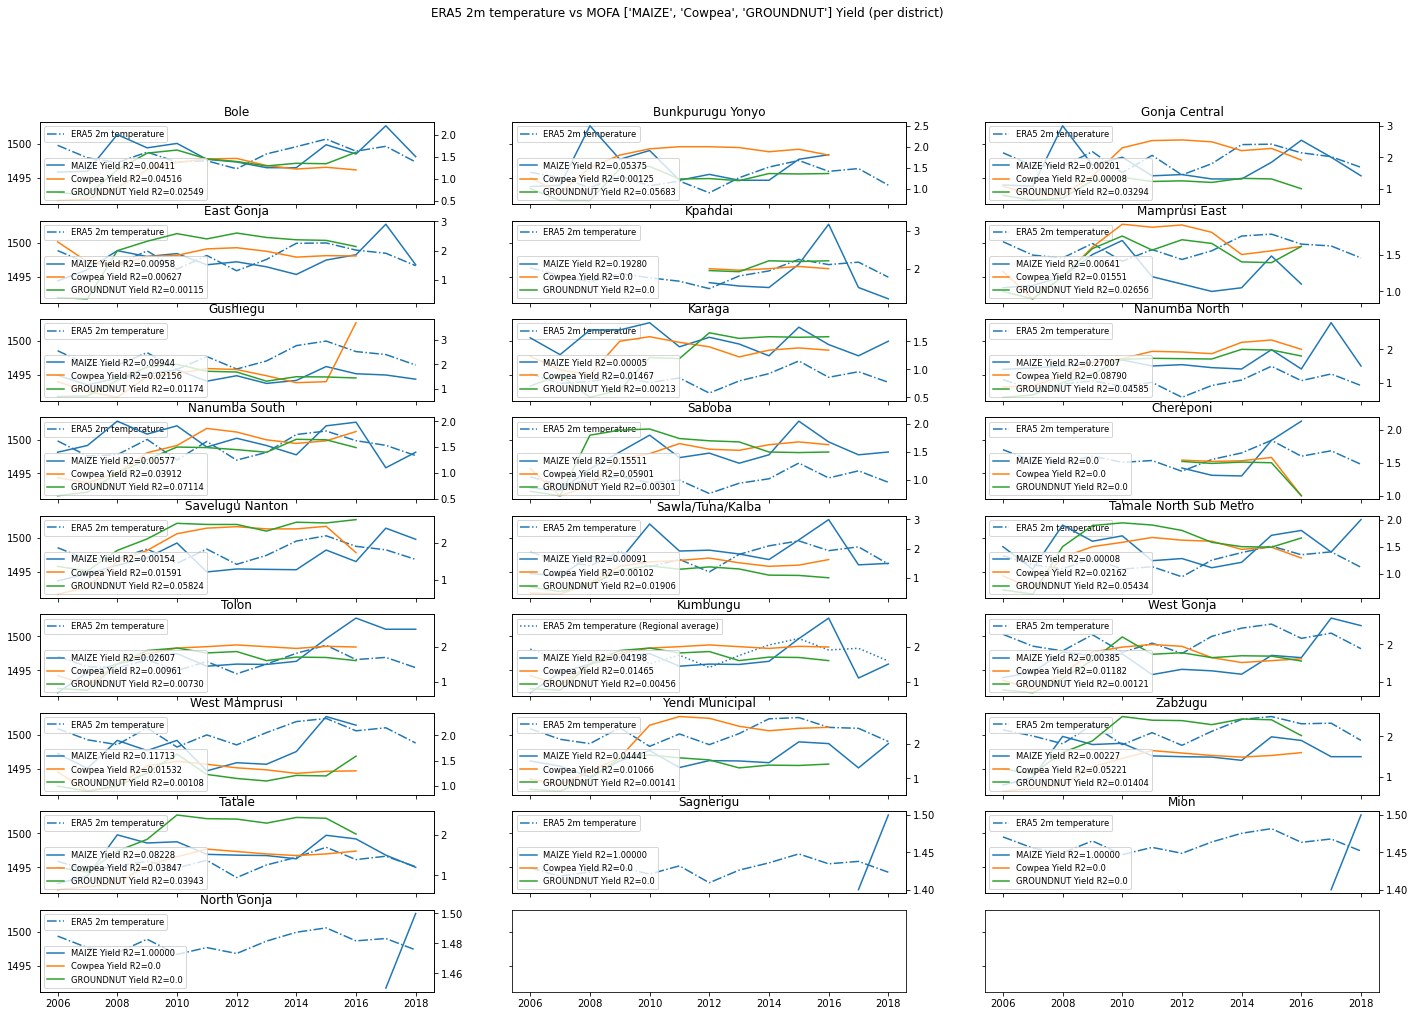

In [57]:
plot_gee_series_vs_mofa_yield(weather_district, weather_ts, \
                              df[df['REGION']=='NORTHERN'], crops=['MAIZE','Cowpea','GROUNDNUT'],\
                             series_name='ERA5 2m temperature', USE_REGIONAL_MEAN=True)

Nextly, we will plot other ERA5 bands as well, e.g. 'volumetric_soil_water_layer_1' is the volume of water in soil layer 1 **(0 - 7 cm)** of the ECMWF Integrated Forecasting System. Other bands e.g. **'evaporation_from_bare_soil' or 'leaf_area_index_high_vegetation' could also be included**

Plotting total_precipitation...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting volumetric_soil_water_layer_1...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data
Plotting leaf_area_index_high_vegetation...
No. of districts:  26 ; No. of years:  13


/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: 

Sagnerigu  does not have MOFA data
Sagnerigu  does not have MOFA data
Mion  does not have MOFA data
Mion  does not have MOFA data
North Gonja  does not have MOFA data
North Gonja  does not have MOFA data


/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/qingling/opt/anaconda3/envs/gee/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


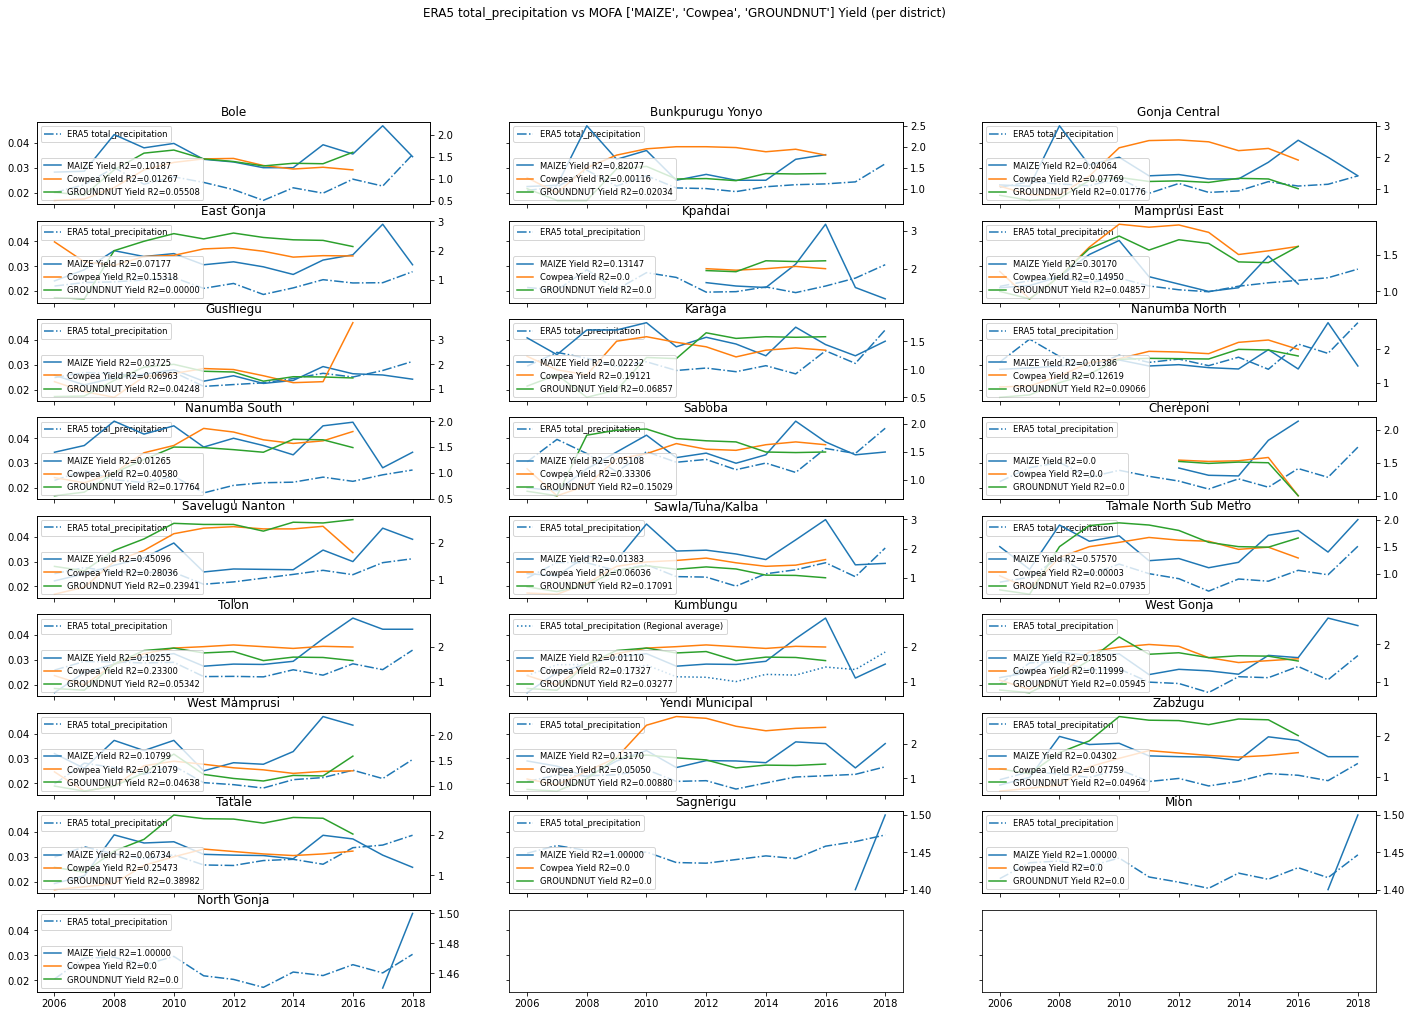

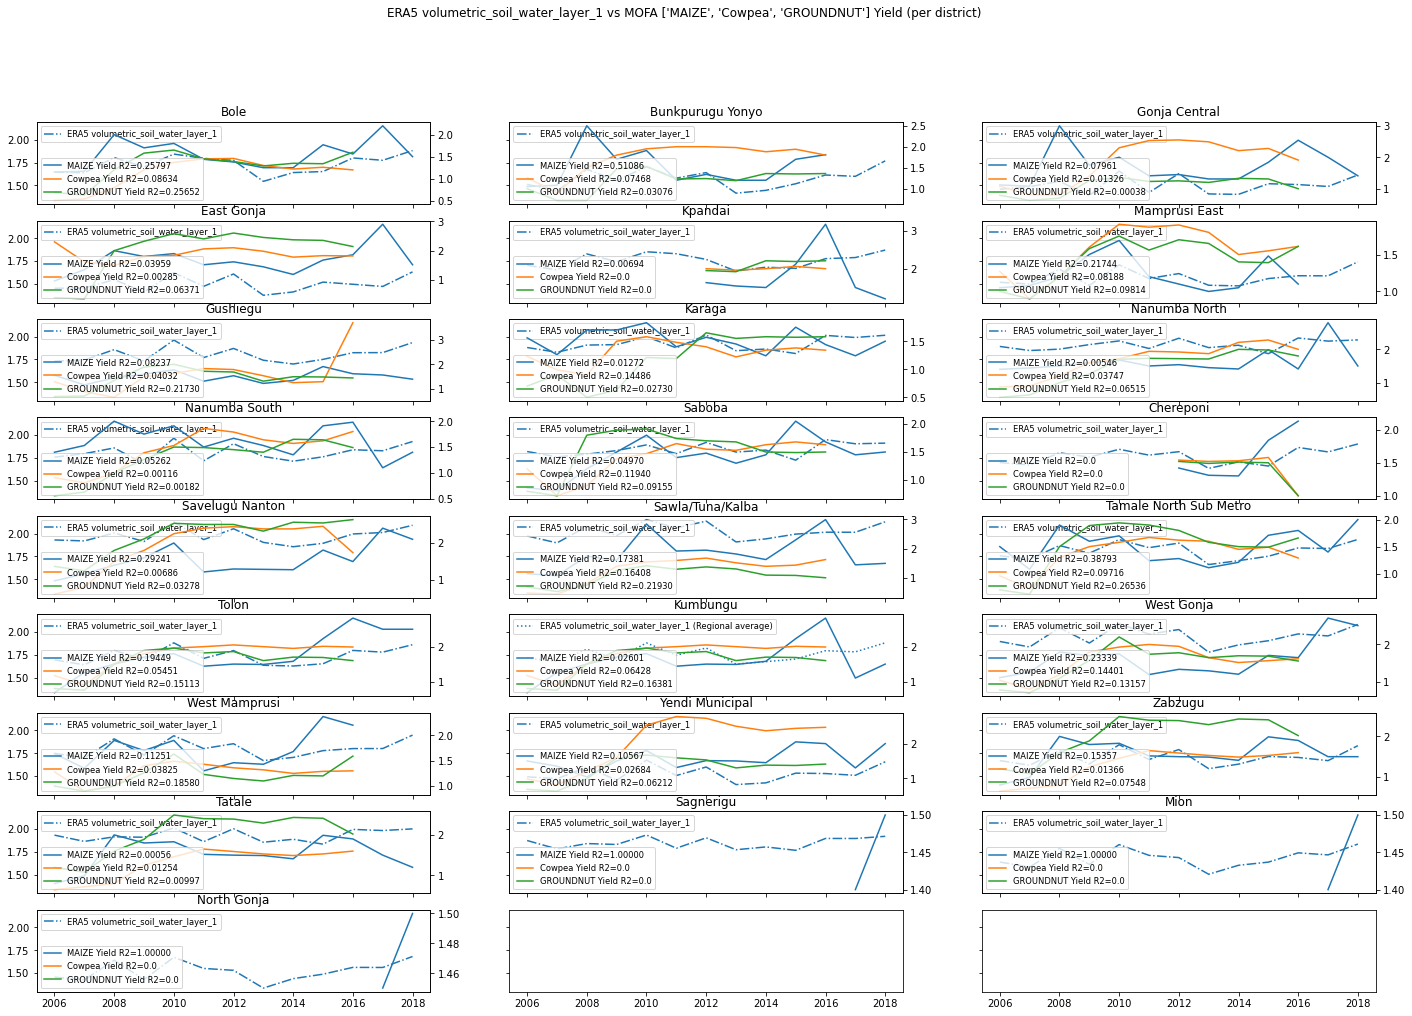

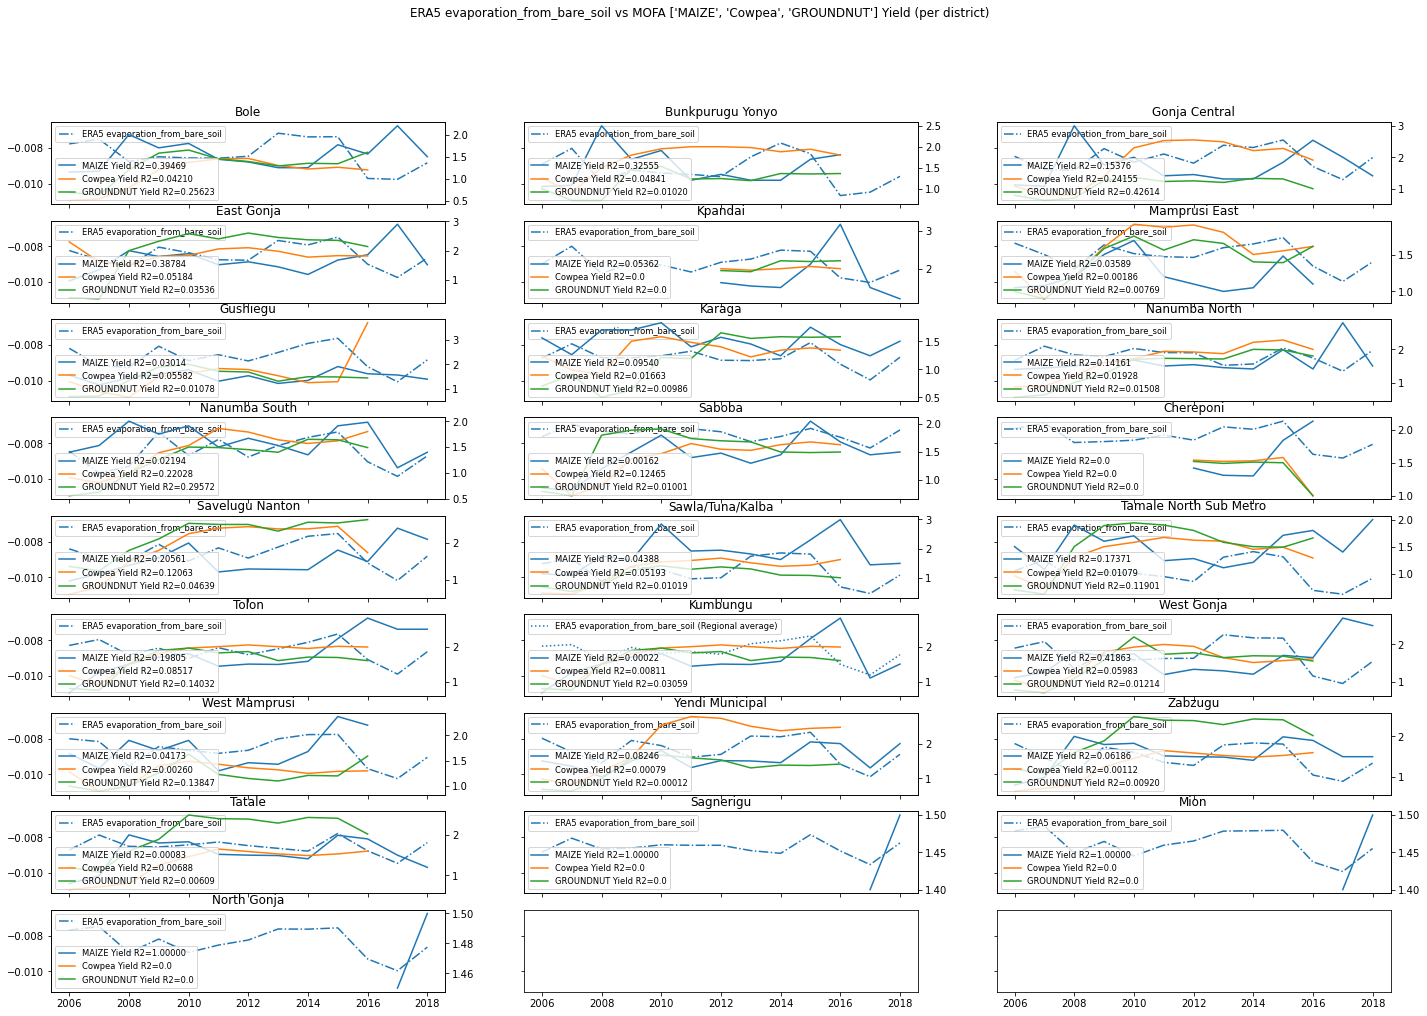

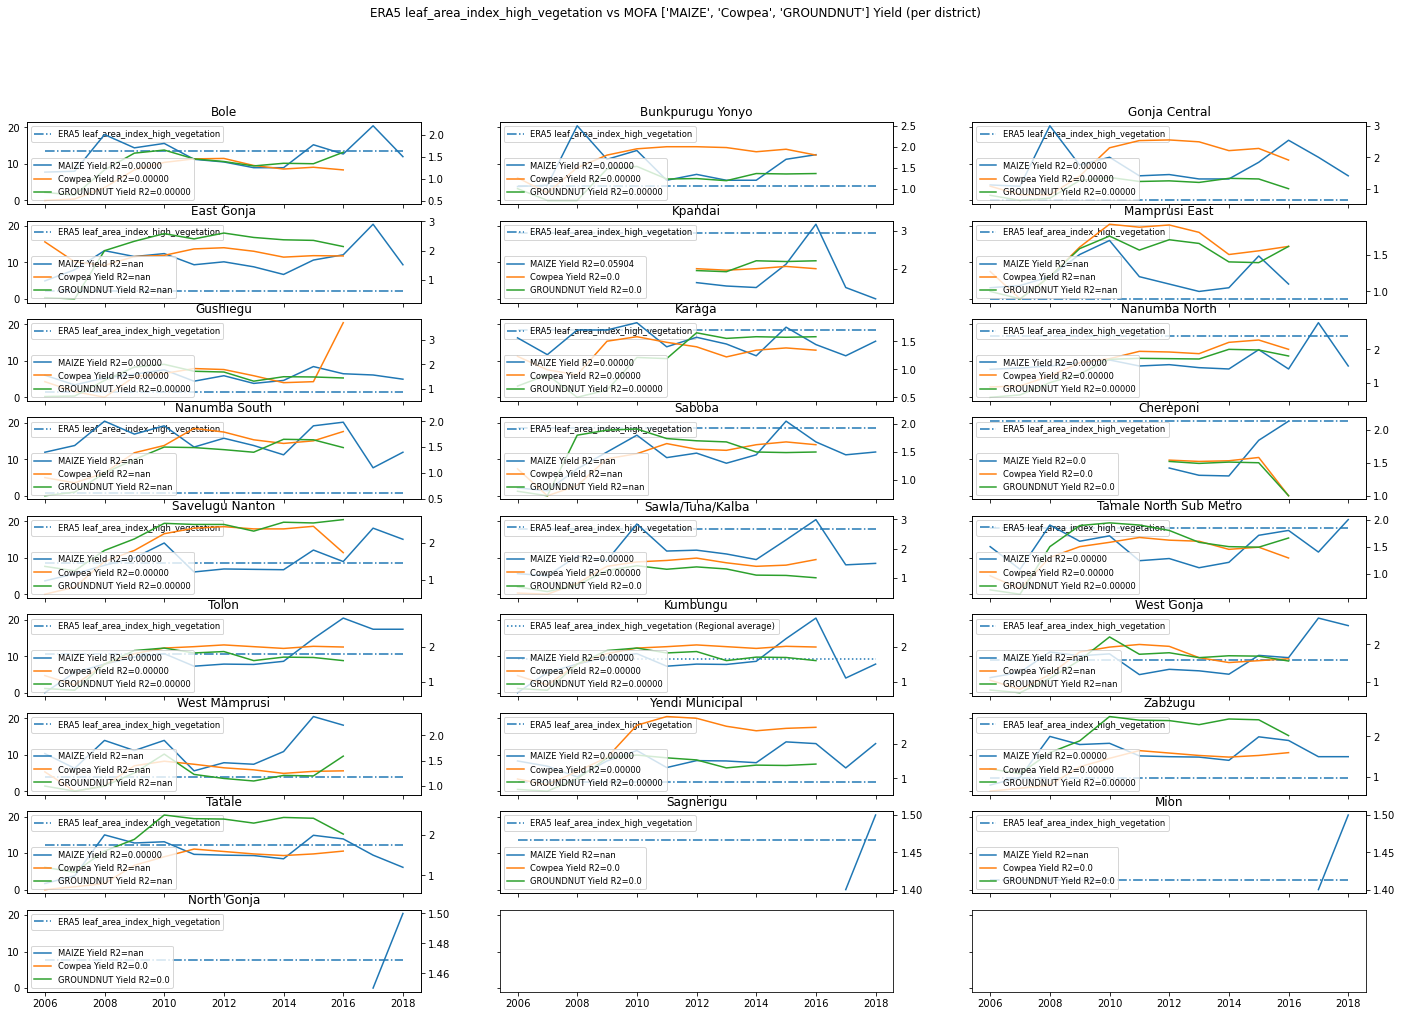

In [58]:
era5_bands = ['total_precipitation', 'volumetric_soil_water_layer_1', \
              'evaporation_from_bare_soil', 'leaf_area_index_high_vegetation']

for band in era5_bands:
    print(f'Plotting {band}...')
    weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), northern_district, \
                                                        band=band)
    plot_gee_series_vs_mofa_yield(weather_district, weather_ts, \
                              df[df['REGION']=='NORTHERN'], crops=['MAIZE','Cowpea','GROUNDNUT'],\
                             series_name='ERA5 '+ band, USE_REGIONAL_MEAN=True)

Based on the previous plots, 'leaf_area_index_high_vegetation' seems to have little data, so let's drop it. The other three bands have high colinearity, so let's just work on one of them for now.

In [60]:
def linreg_era5_one_band_with_yield(df_northern_maize, era5_band, VERBOSE=False):
    print(f'Retreiving ERA5 monthly {band}...')
    weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                                        northern_district, band=era5_band)
    #print(weather_district.size, weather_ts.size, len(weather_ts))

    '''creating a DF for each distrct and run Linear Reg on each district 
    between YIELD anD (vi, temperature, percip)'''
    for d, district in enumerate(weather_district):
        if VERBOSE: print('Initiating a DF from MODIS LAI as the 1st indenpendent var')
        df_data = pd.DataFrame(max_MODIS_LAIs[d], columns=['MODIS Lai']) 
        
        df_era5 = pd.DataFrame(weather_ts[d], columns=[band])
        if VERBOSE: print('Adding ERA5 varibale as another indenpendent var')
        df_data = pd.concat((df_data, df_era5), axis=1)
        if VERBOSE: print(district, df_data)
        #print(df_era5.size)
        
        df_district = df_northern_maize[df_northern_maize['DISTRICT']==district]
        #print(f"{df_district['YIELD'].size} year(s) of MOFA Yield data: \n{df_district['YIELD']}")
        
        if (df_district['YIELD'].size == int(END_YEAR - MIN_YEAR + 1)) and (df_district['YIELD'].size >3):

            mlr = LinearRegression()
            # df_data include and only include the indepedent variables
            # denpendent variable should be MOFA Yield
            mlr.fit(df_data, df_district['YIELD'])
            #print(f'{district} intercept = {mlr.intercept_}')
            #print('\t Coefficients: ', mlr.coef_)
            y_pred = mlr.predict(df_data)
            
            # The mean squared error
            if VERBOSE: print('Mean squared error: %.2f' % mean_squared_error(df_district['YIELD'], y_pred))
            # The coefficient of determination: 1 is perfect prediction
            if VERBOSE: print('R2: %.2f' % r2_score(df_district['YIELD'], y_pred))
            
            plt.scatter(df_district['YIELD'], y_pred, label=district + ' R2: %.2f'
                  % r2_score(df_district['YIELD'], y_pred))
        
        else: 
            print(f'Not enough MOFA YIELD for {district}')

    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.title(f'Ghana Yield = a*MaxLAI +b*{era5_band}')
    plt.show()

Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
Not enough MOFA YIELD for Bunkpurugu Yonyo
Not enough MOFA YIELD for Mamprusi East
Not enough MOFA YIELD for Chereponi
Not enough MOFA YIELD for Kpandai
Not enough MOFA YIELD for North Gonja
Not enough MOFA YIELD for Mion
Not enough MOFA YIELD for Kumbumgu
Not enough MOFA YIELD for West Mamprusi
Not enough MOFA YIELD for Mamprugu Moagduri
Not enough MOFA YIELD for Sagnerigu


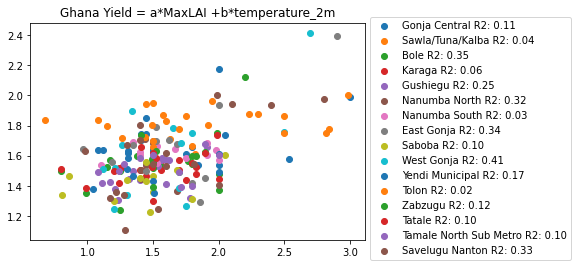

Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
Not enough MOFA YIELD for Bunkpurugu Yonyo
Not enough MOFA YIELD for Mamprusi East
Not enough MOFA YIELD for Chereponi
Not enough MOFA YIELD for Kpandai
Not enough MOFA YIELD for North Gonja
Not enough MOFA YIELD for Mion
Not enough MOFA YIELD for Kumbumgu
Not enough MOFA YIELD for West Mamprusi
Not enough MOFA YIELD for Mamprugu Moagduri
Not enough MOFA YIELD for Sagnerigu


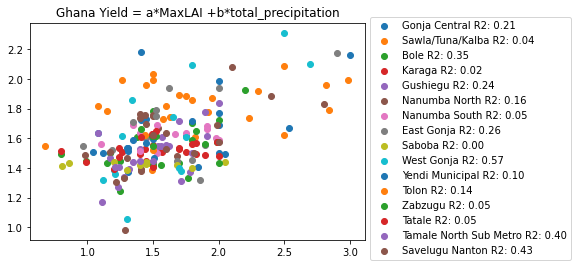

In [61]:
era5_bands = ['temperature_2m', 'total_precipitation']

for band in era5_bands:
    linreg_era5_one_band_with_yield(df_northern_maize, band, VERBOSE=False)

In [62]:
def linreg_era5_with_yield(df_northern_maize, era5_bands, VERBOSE=False):
    
    title = f'Ghana Yield = a+0*MaxLAI'
    
    for i, era5_band in enumerate(era5_bands):
        print(f'Retreiving ERA5 monthly {era5_band}...')
        weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                                        northern_district, band=era5_band)
        #print(weather_district.size, weather_ts.size, len(weather_ts))
        if i ==0:
            weather_array = np.array(weather_ts)
            weather_array = np.expand_dims(weather_array, axis=0)
        else:
            print(weather_ts.size)
            weather_array = np.append(weather_array, [weather_ts], axis=0)
        print(weather_array.size, weather_array.shape)
        title = title + f'+b*{era5_band}'

    '''creating a DF for each distrct and run Linear Reg on each district 
    between YIELD anD (vi, temperature, percip)'''
    for d, district in enumerate(weather_district):
        if VERBOSE: print('Initiating a DF from MODIS LAI as the 1st indenpendent var')
        df_data = pd.DataFrame(max_MODIS_LAIs[d], columns=['MODIS Lai']) 
        
        for j in range(weather_array.shape[0]):
            df_era5 = pd.DataFrame(weather_array[j,d], columns=[era5_bands[j]])
            if VERBOSE: print('Adding ERA5 varibale as another indenpendent var')
            df_data = pd.concat((df_data, df_era5), axis=1)
            if VERBOSE: print(district, df_data)
            if VERBOSE: print(df_era5.size)
        
        df_district = df_northern_maize[df_northern_maize['DISTRICT']==district]
        #print(f"{df_district['YIELD'].size} year(s) of MOFA Yield data: \n{df_district['YIELD']}")
        
        if (df_district['YIELD'].size == int(END_YEAR - MIN_YEAR + 1)) and (df_district['YIELD'].size >3):

            mlr = LinearRegression()
            # df_data include and only include the indepedent variables
            # denpendent variable should be MOFA Yield
            mlr.fit(df_data[era5_bands], df_district['YIELD'])
            #print(f'{district} intercept = {mlr.intercept_}')
            #print('\t Coefficients: ', mlr.coef_)
            y_pred = mlr.predict(df_data[era5_bands])
            print(district, mlr.intercept_, mlr.coef_)
            
            # The mean squared error
            if VERBOSE: print('Mean squared error: %.2f' % mean_squared_error(df_district['YIELD'], y_pred))
            # The coefficient of determination: 1 is perfect prediction
            if VERBOSE: print('R2: %.2f' % r2_score(df_district['YIELD'], y_pred))
            
            plt.scatter(df_district['YIELD'], y_pred, label=district + ' R2: %.2f'
                  % r2_score(df_district['YIELD'], y_pred))
        
        else: 
            print(f'Not enough MOFA YIELD for {district}')

    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.title(title)
    plt.show()

Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
338 (1, 26, 13)
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
338
676 (2, 26, 13)
Gonja Central -101.50066938107457 [ 0.06799931 55.10308555]
Sawla/Tuna/Kalba -12.477515038096543 [9.25546418e-03 2.02633896e+01]
Not enough MOFA YIELD for Bunkpurugu Yonyo
Not enough MOFA YIELD for Mamprusi East
Bole -146.34761423173325 [ 0.0981573  47.79063342]
Karaga 41.33685801759966 [-0.02664126  4.68880244]
Gushiegu -79.63039453023103 [ 0.05386232 18.34858127]
Nanumba North -213.12474251192893 [ 0.14377862 -4.03414602]
Nanumba South 43.658480570526685 [ -0.02787727 -11.63150509]
Not enough MOFA YIELD for Chereponi
Not enough MOFA YIELD for Kpandai
East Gonja -71.97956177078838 [ 0.04890244 16.81087738]
Saboba -120.54849221189775 [0.08140472 1.33739529]
Not enough MOFA YIELD for North Gonja
West Gonja -239.8217193836598 [ 0.15995431 81.45466888]
Not enough MOFA YIELD for Mion


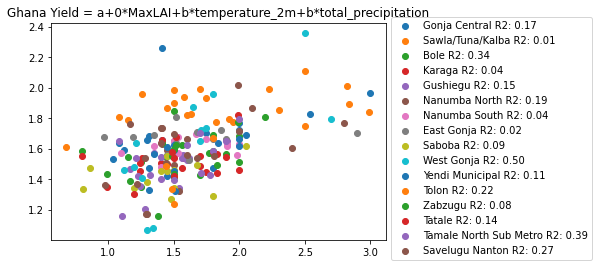

In [63]:
linreg_era5_with_yield(df_northern_maize, ['temperature_2m', 'total_precipitation'], VERBOSE=False)

Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
338 (1, 26, 13)
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
338
676 (2, 26, 13)
Retreiving ERA5 monthly evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
338
1014 (3, 26, 13)
Gonja Central -95.54506530136267 [ 6.25494915e-02  1.97528217e+01 -3.66396457e+02]
Sawla/Tuna/Kalba -61.432919948786555 [ 4.07767724e-02 -1.93763328e+00 -2.55520317e+02]
Not enough MOFA YIELD for Bunkpurugu Yonyo
Not enough MOFA YIELD for Mamprusi East
Bole -118.83479098430556 [ 7.87608075e-02  2.53939699e+01 -2.23578291e+02]
Karaga 89.45001980287768 [-5.80276684e-02  2.54508164e+01  1.82753065e+02]
Gushiegu -68.86030123417886 [ 0.04680426 19.97066091 27.72731482]
Nanumba North -236.37828314821158 [ 1.57002989e-01 -5.75569173e+00 -4.06734713e+02]
Nanumba South 1.0508652902612305 [ 3.18739165e-03 -1.81398243e+01  4.14886911e+02]
Not enough MOFA YIELD for Chereponi
No

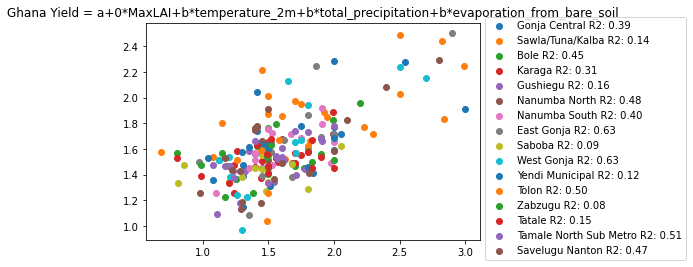

In [64]:
linreg_era5_with_yield(df_northern_maize, ['temperature_2m', 'total_precipitation',\
                                           'evaporation_from_bare_soil'], VERBOSE=False)

1. basic correlation of yield and modis?
2. contact kofi for further data
3. exploratory data
4. correlations between 
5. literature of similar exploratory analysis 
6. direct analysis (argonomical) of how maize growth is affected by e.g. moisture during xx period;
Jose: to sent modis data
QL: to ask JULES guy at bristol ; NP report

## Next, run one overall model instead of separate districts

In [65]:
df_lai = pd.DataFrame(max_MODIS_LAIs, columns=range(MIN_YEAR,END_YEAR+1))
#df_lai.head()
df_lai.insert(0, 'District', GAUL_district_names)
df_lai = df_lai.melt(id_vars=['District']).rename(\
                    columns={'variable':'Year','value':'MaxLAI'})
df_lai

District  Year    MaxLAI
0             Gonja Central  2006  4.025129
1          Sawla/Tuna/Kalba  2006  3.780723
2          Bunkpurugu Yonyo  2006  3.067568
3             Mamprusi East  2006  3.322553
4                      Bole  2006  3.756777
..                      ...   ...       ...
333                 Zabzugu  2018  4.347778
334                  Tatale  2018  4.320492
335  Tamale North Sub Metro  2018  4.305457
336               Sagnerigu  2018  1.679416
337         Savelugu Nanton  2018  3.752840

[338 rows x 3 columns]

In [66]:
era5_bands = ['temperature_2m', 'total_precipitation']

for i, era5_band in enumerate(era5_bands):
    print(f'Retreiving ERA5 monthly {era5_band}...')
    weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                        northern_district, band=era5_band, CROPONLY=True)
    print(weather_district.size, weather_ts.size, len(weather_ts))
    
    df_weather = pd.DataFrame(weather_ts, columns=range(MIN_YEAR,END_YEAR+1))
    df_weather.insert(0, 'District', weather_district)
    #print(df_weather.head())
    
    df_weather = df_weather.melt(id_vars=['District']).rename(\
                    columns={'variable':'Year','value':era5_band})
    #print(df_weather.head(50))
    
    if i == 0:
        df_output = df_weather
    else:
        df_output = df_output.merge(df_weather, on=["District", "Year"])
        #print(df_output.head(50))

Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
26 338 26
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
26 338 26


In [67]:
df_output

District  Year  temperature_2m  total_precipitation
0             Gonja Central  2006     1499.824580             0.020030
1          Sawla/Tuna/Kalba  2006     1495.860915             0.020903
2          Bunkpurugu Yonyo  2006     1498.725469             0.022127
3             Mamprusi East  2006     1498.820404             0.022030
4                      Bole  2006     1496.287094             0.021450
..                      ...   ...             ...                  ...
333                 Zabzugu  2018     1495.097218             0.038706
334                  Tatale  2018     1494.278988             0.038822
335  Tamale North Sub Metro  2018     1497.394303             0.030846
336               Sagnerigu  2018     1497.333349             0.030438
337         Savelugu Nanton  2018     1498.147474             0.028990

[338 rows x 4 columns]

In [68]:
df_northern_maize[['DISTRICT', 'YEAR', 'YIELD']]

DISTRICT  YEAR  YIELD
44     Gonja Central  2006   1.12
45        West Gonja  2006   1.12
46   Yendi Municipal  2006   1.50
47     Nanumba North  2006   1.40
48     Nanumba South  2006   1.40
..               ...   ...    ...
727           Tatale  2018   1.20
728          Zabzugu  2018   1.50
729        Sagnerigu  2018   1.50
730             Mion  2018   1.50
731      North Gonja  2018   1.50

[272 rows x 3 columns]

In [128]:
def linreg_era5_with_yield_overall(df_northern_maize, era5_bands, INCLUDE_LAI=True, VERBOSE=False):
    df_inpt, df_dep = generate_era5_and_yield_DF(df_northern_maize, era5_bands, INCLUDE_LAI=INCLUDE_LAI, VERBOSE=VERBOSE)
    
    if not(df_inpt.empty) and not(df_dep.empty):
        
        mlr = LinearRegression()            
        mlr.fit(df_inpt, df_dep)
        y_pred = mlr.predict(df_inpt)
            
        if VERBOSE: 
            print(f'{district} intercept = {mlr.intercept_}')
            print('\t Coefficients: ', mlr.coef_)
            # The mean squared error
            print('Mean squared error: %.2f' % mean_squared_error(df_dep, y_pred))
            # The coefficient of determination: 1 is perfect prediction
            print('R2: %.2f' % r2_score(df_dep, y_pred))
            
        plt.scatter(df_dep, y_pred, label=' R2: %.2f'
                  % r2_score(df_dep, y_pred))

        plt.legend(bbox_to_anchor=(1, 1.05))
        #plt.title(title)
        plt.show()
        
    return df_inpt, df_dep

816 yield samples found in MOFA record
            DISTRICT  YEAR  YIELD
44     Gonja Central  2006   1.12
45        West Gonja  2006   1.12
46   Yendi Municipal  2006   1.50
47     Nanumba North  2006   1.40
48     Nanumba South  2006   1.40
49            Karaga  2006   1.56
50          Gushiegu  2006   1.56
51  Bunkpurugu Yonyo  2006   1.05
52     Mamprusi East  2006   1.05
53   Savelugu Nanton  2006   0.98
1014 samples found in MODIS Max LAI record
Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
26 338 26
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
26 338 26
Retreiving ERA5 monthly evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
26 338 26
2028 matching samples found in ERA5 record
           DISTRICT  YEAR  temperature_2m  total_precipitation  \
0     Gonja Central  2006     1499.824580             0.020030   
1  Sawla/Tuna/Kalba  2006     1495.860915             0.020903   
2  B

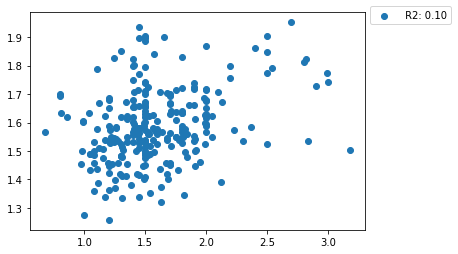

In [129]:
era5_bands = ['temperature_2m', 'total_precipitation', 'evaporation_from_bare_soil']
df_inpt, df_dep = linreg_era5_with_yield_overall(df_northern_maize, era5_bands, VERBOSE=True)

816 yield samples found in MOFA record
1014 samples found in MODIS Max LAI record
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
26 338 26
1352 matching samples found in ERA5 record
           DISTRICT  YEAR  total_precipitation    MaxLAI
0     Gonja Central  2006             0.020030  4.025129
1  Sawla/Tuna/Kalba  2006             0.020903  3.780723
2  Bunkpurugu Yonyo  2006             0.022127  3.067568
3     Mamprusi East  2006             0.022030  3.322553
4              Bole  2006             0.021450  3.756777
1295 matching yield samples found
<bound method NDFrame.head of             DISTRICT  YEAR  YIELD  total_precipitation    MaxLAI
0      Gonja Central  2006   1.12             0.020030  4.025129
1         West Gonja  2006   1.12             0.021739  4.072109
2    Yendi Municipal  2006   1.50             0.025401  4.578493
3      Nanumba North  2006   1.40             0.029395  4.335189
4      Nanumba South  2006   1.40            

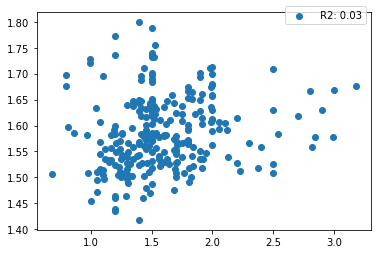

(     total_precipitation    MaxLAI
 0               0.020030  4.025129
 1               0.021739  4.072109
 2               0.025401  4.578493
 3               0.029395  4.335189
 4               0.031020  4.128545
 ..                   ...       ...
 254             0.038822  4.320492
 255             0.038706  4.347778
 256             0.030438  1.679416
 257             0.033967  4.451057
 258             0.035441  4.281519
 
 [259 rows x 2 columns],
 0      1.12
 1      1.12
 2      1.50
 3      1.40
 4      1.40
        ... 
 254    1.20
 255    1.50
 256    1.50
 257    1.50
 258    1.50
 Name: YIELD, Length: 259, dtype: float64)

In [130]:
era5_bands = ['total_precipitation']
linreg_era5_with_yield_overall(df_northern_maize, era5_bands, VERBOSE=False)

816 yield samples found in MOFA record
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
26 338 26
1014 matching samples found in ERA5 record
           DISTRICT  YEAR  total_precipitation
0     Gonja Central  2006             0.020030
1  Sawla/Tuna/Kalba  2006             0.020903
2  Bunkpurugu Yonyo  2006             0.022127
3     Mamprusi East  2006             0.022030
4              Bole  2006             0.021450
1036 matching yield samples found
<bound method NDFrame.head of             DISTRICT  YEAR  YIELD  total_precipitation
0      Gonja Central  2006   1.12             0.020030
1         West Gonja  2006   1.12             0.021739
2    Yendi Municipal  2006   1.50             0.025401
3      Nanumba North  2006   1.40             0.029395
4      Nanumba South  2006   1.40             0.031020
..               ...   ...    ...                  ...
254           Tatale  2018   1.20             0.038822
255          Zabzugu  2018   1.50

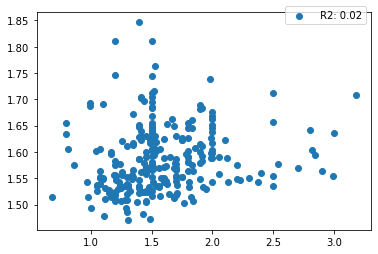

In [73]:
era5_bands = ['total_precipitation']
linreg_era5_with_yield_overall(df_northern_maize, era5_bands, INCLUDE_LAI=False, VERBOSE=False)

## try linreg per year

In [120]:
def linreg_era5_with_yield_per_year(df_northern_maize, era5_bands, INCLUDE_LAI=True, VERBOSE=False):
    '''Make a DF of dependent variable, YIELD'''
    
    df_yield = df_northern_maize[['DISTRICT', 'YEAR', 'YIELD']]
    print(f'{df_yield.size} yield samples found in MOFA record')
    if VERBOSE: print(df_yield.head(10))
                            
    if INCLUDE_LAI:
        '''Make a DF of MAXLai data'''
        df_lai = pd.DataFrame(max_MODIS_LAIs, columns=range(MIN_YEAR,END_YEAR+1))
        #df_lai.head()
        df_lai.insert(0, 'DISTRICT', GAUL_district_names)
        df_lai = df_lai.melt(id_vars=['DISTRICT']).rename(\
                        columns={'variable':'YEAR','value':'MaxLAI'})
        print(f'{df_lai.size} samples found in MODIS Max LAI record')
    
    '''Make a DF of ERA5 data'''
    for i, era5_band in enumerate(era5_bands):
        print(f'Retreiving ERA5 monthly {era5_band}...')
        weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                            northern_district, band=era5_band, CROPONLY=True)
        print(weather_district.size, weather_ts.size, len(weather_ts))

        df_weather = pd.DataFrame(weather_ts, columns=range(MIN_YEAR,END_YEAR+1))
        df_weather.insert(0, 'DISTRICT', weather_district)
        #print(df_weather.head())

        df_weather = df_weather.melt(id_vars=['DISTRICT']).rename(\
                        columns={'variable':'YEAR','value':era5_band})
        #print(df_weather.head(50))

        if i == 0:
            df_era5 = df_weather
        else:
            df_era5 = df_era5.merge(df_weather, on=["DISTRICT", "YEAR"])
            #print(df_output.head(50))
        
    '''Merge LAI and ERA5 DFs'''
    if INCLUDE_LAI: 
        df_indp = df_era5.merge(df_lai, on=["DISTRICT", "YEAR"]) 
    else:
        df_indp = df_era5
    print(f'{df_indp.size} matching samples found in ERA5 record')
    #print(df_indp.head())

    if df_indp.size > 0:
        df_yield = df_yield.merge(df_indp, on=["DISTRICT", "YEAR"])
        #print(df_yield.head)
        #df_yield = df_yield[['DISTRICT', 'YEAR', 'YIELD']]
        print(f'{df_yield.size} matching yield samples found')
        #print(df_yield.head)
        
        if df_yield.size >0:
            mlr = LinearRegression()
            # denpendent variable should be MOFA Yield
            if INCLUDE_LAI: 
                era5_bands.append('MaxLAI')
            print('Indepedent variables are:', era5_bands)
        
            for year in range(MIN_YEAR,END_YEAR+1):
                if VERBOSE: print(year)
                df_yield_y = df_yield[df_yield['YEAR']==year]

                df_inp = df_yield_y[era5_bands]
                #print(df_inp.head())

                mlr.fit(df_inp, df_yield_y['YIELD'])
                #print(f'{district} intercept = {mlr.intercept_}')
                #print('\t Coefficients: ', mlr.coef_)
                y_pred = mlr.predict(df_inp)

                # The mean squared error
                if VERBOSE: print('Mean squared error: %.2f' % mean_squared_error(df_yield_y['YIELD'], y_pred))
                # The coefficient of determination: 1 is perfect prediction
                if VERBOSE: print('R2: %.2f' % r2_score(df_yield_y['YIELD'], y_pred))

                plt.scatter(df_yield_y['YIELD'], y_pred, label=str(year)+' R2: %.2f'
                      % r2_score(df_yield_y['YIELD'], y_pred))

        else: 
            print(f'Not enough ERA5 data')

    plt.legend(bbox_to_anchor=(1, 1.05))
    #plt.title(title)
    plt.show()

816 yield samples found in MOFA record
1014 samples found in MODIS Max LAI record
Retreiving ERA5 monthly temperature_2m...
No. of districts:  26 ; No. of years:  13
26 338 26
Retreiving ERA5 monthly total_precipitation...
No. of districts:  26 ; No. of years:  13
26 338 26
Retreiving ERA5 monthly evaporation_from_bare_soil...
No. of districts:  26 ; No. of years:  13
26 338 26
2028 matching samples found in ERA5 record
1813 matching yield samples found
Indepedent variables are: ['temperature_2m', 'total_precipitation', 'evaporation_from_bare_soil', 'MaxLAI']
Not enough ERA5 data


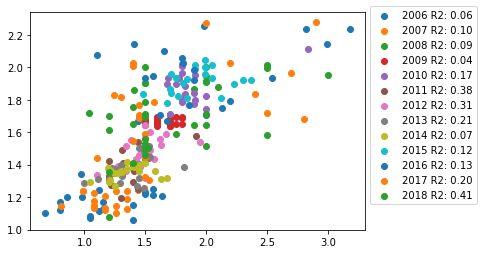

In [121]:
era5_bands = ['temperature_2m', 'total_precipitation', 'evaporation_from_bare_soil']
linreg_era5_with_yield_per_year(df_northern_maize, era5_bands, VERBOSE=False)

# Try non-linear fit model

In [93]:
from scipy.optimize import curve_fit

def fit_era5_with_yield_overall(df_northern_maize, era5_bands, VERBOSE=False):
    '''Make a DF of dependent variable, YIELD'''
    
    df_yield = df_northern_maize[['DISTRICT', 'YEAR', 'YIELD']]
    print(f'{df_yield.size} yield samples found in MOFA record')
    if VERBOSE: print(df_yield.head(10))
                            
    '''Make a DF of MAXLai data'''
    df_lai = pd.DataFrame(max_MODIS_LAIs, columns=range(MIN_YEAR,END_YEAR+1))
    #df_lai.head()
    df_lai.insert(0, 'DISTRICT', GAUL_district_names)
    df_lai = df_lai.melt(id_vars=['DISTRICT']).rename(\
                    columns={'variable':'YEAR','value':'MaxLAI'})
    print(f'{df_lai.size} samples found in MODIS Max LAI record')
    
    '''Make a DF of ERA5 data'''
    for i, era5_band in enumerate(era5_bands):
        print(f'Retreiving ERA5 monthly {era5_band}...')
        weather_district, weather_ts = era5_ts_per_district(range(MIN_YEAR,END_YEAR+1), \
                                            northern_district, band=era5_band, CROPONLY=True)
        print(weather_district.size, weather_ts.size, len(weather_ts))

        df_weather = pd.DataFrame(weather_ts, columns=range(MIN_YEAR,END_YEAR+1))
        df_weather.insert(0, 'DISTRICT', weather_district)
        #print(df_weather.head())

        df_weather = df_weather.melt(id_vars=['DISTRICT']).rename(\
                        columns={'variable':'YEAR','value':era5_band})
        #print(df_weather.head(50))

        if i == 0:
            df_era5 = df_weather
        else:
            df_era5 = df_era5.merge(df_weather, on=["DISTRICT", "YEAR"])
            #print(df_output.head(50))
        
    '''Merge LAI and ERA5 DFs'''
    df_indp = df_era5.merge(df_lai, on=["DISTRICT", "YEAR"])    
    print(f'{df_indp.size} matching samples found in ERA5 record')
    print(df_indp.head())

    if df_indp.size > 0:
        df_yield = df_yield.merge(df_indp, on=["DISTRICT", "YEAR"])
        #print(df_yield.head)
        #df_yield = df_yield[['DISTRICT', 'YEAR', 'YIELD']]
        print(f'{df_yield.size} matching yield samples found')
        print(df_yield.head)
        
        if df_yield.size >0:
            mlr = LinearRegression()
            # denpendent variable should be MOFA Yield
            era5_bands.append('MaxLAI')
            print('Indepedent variables are:', era5_bands)
            df_inp = df_yield[era5_bands]
            
            mlr.fit(df_inp, df_yield['YIELD'])
            #print(f'{district} intercept = {mlr.intercept_}')
            #print('\t Coefficients: ', mlr.coef_)
            y_pred = mlr.predict(df_inp)
            
            # The mean squared error
            if VERBOSE: print('Mean squared error: %.2f' % mean_squared_error(df_yield['YIELD'], y_pred))
            # The coefficient of determination: 1 is perfect prediction
            if VERBOSE: print('R2: %.2f' % r2_score(df_yield['YIELD'], y_pred))
            
            plt.scatter(df_yield['YIELD'], y_pred, label=' R2: %.2f'
                  % r2_score(df_yield['YIELD'], y_pred))
        
        else: 
            print(f'Not enough ERA5 data')

    plt.legend(bbox_to_anchor=(1, 1.05))
    #plt.title(title)
    plt.show()